In [257]:
import pandas as pd
import numpy as np
import pickle
import sys
from tqdm import tqdm
import seaborn as snb
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from utils.tools import *

In [258]:
import argparse
sys.argv = ['structure.py']
parser = argparse.ArgumentParser()
parser.add_argument('--Dim', type=int, default=3)
parser.add_argument('--Nodes_num', type=int, default=20)
parser.add_argument('--dt', type=float, default=0.01)
parser.add_argument('--Net', type=str, default='ER', help='BA, Di_BA or ER')
parser.add_argument('--Model', type=str, default='HR', help='Attractor')
parser.add_argument('--Time', type=int, default=500, help='T_time, default=10')
parser.add_argument('--Batch', type=int, default=256, help='BatchSize, default=4096')
parser.add_argument('--Hidden', type=int, default=50, help='Hidden Neurons')

args, unknown = parser.parse_known_args()

lam = None
tau_up = 0.999

In [259]:
data_path = 'data/'
save_path = 'Training_process/'

In [260]:
from utils.model import *
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
nodes_num = args.Nodes_num

aggr = 'add'
model = 'HR'
hidden = args.Hidden
n_f = 3
dt = args.dt
msg_dim = 1
dim = args.Dim

In [261]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999_lam0.0001_20251013_191841.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 1999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

In [262]:
len(np.where(objectAij==-1)[0]) # true inhibitory edges

58

In [263]:
len(np.where(objectAij==1)[0]) # true excitatory edges

42

In [264]:
import torch
import torch.nn.functional as F
    
nodes_num = args.Nodes_num
Accuracy = []
threshold = 0.5

def get_binary_weight_error(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-0.5,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>0.5,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-0.5) & (bi_bestWei<0.5),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        error = np.sum(np.abs(bi_bestWei_alllinks - objectAij.reshape(-1,1)))/(nodes_num*(nodes_num-1))
        Accuracy.append(1-error)
    return Accuracy

Accu = get_binary_weight_error(weights_over_epcs,0.5)

triple classificatio: calculate precision and recall value for each class, then calculate $f1-score=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [265]:
from sklearn.metrics import f1_score
inhedge = []
exiedge = []
noedge = []

def get_weight_f1score(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-threshold,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>threshold,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-threshold) & (bi_bestWei<threshold),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        nscore, zscore, pscore = f1_score(objectAij.reshape(-1,1), bi_bestWei_alllinks, average=None)
        # nscore, zscore, pscore = f1_score(objectAij.reshape(-1,1), -bi_bestWei_alllinks, average=None) # if the inferred edge sign is reversed
        inhedge.append(nscore)
        noedge.append(zscore)
        exiedge.append(pscore)
    return inhedge, noedge, exiedge
inhedge, noedge, exiedge = get_weight_f1score(weights_over_epcs,0.5)

(2000, 3)


/tmp/ipykernel_104768/1246450518.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
/tmp/ipykernel_104768/1246450518.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)
/tmp/ipykernel_104768/1246450518.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

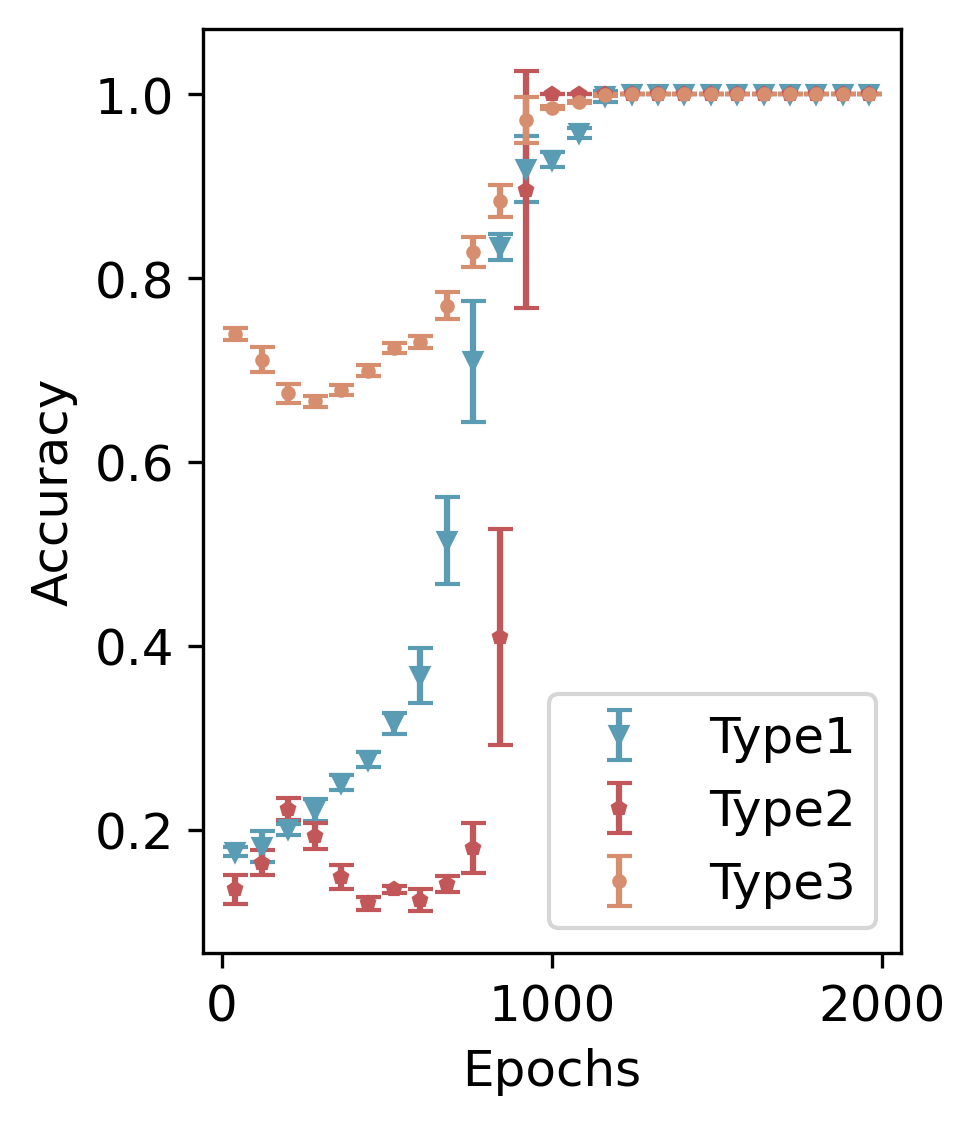

In [266]:
import matplotlib.pyplot as plt
import numpy as np

Eval = pd.DataFrame()   
Eval['inhedge_accu'] = inhedge
Eval['noedge_accu'] = noedge
Eval['exiedge_accu'] = exiedge
print(Eval.shape)
Evaluation = Eval[0:2000]
Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)

inhedge_stats = Evaluation.groupby('x_bin')['inhedge_accu'].agg(['mean', 'std'])
inhedge_centers = inhedge_stats.index.map(lambda x: x.mid).astype(float)
exiedge_stats = Evaluation.groupby('x_bin')['exiedge_accu'].agg(['mean', 'std'])
exiedge_centers = exiedge_stats.index.map(lambda x: x.mid).astype(float)
noedge_stats = Evaluation.groupby('x_bin')['noedge_accu'].agg(['mean', 'std'])
noedge_centers = noedge_stats.index.map(lambda x: x.mid).astype(float)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(3,4))

# palette = ['#C25759','#599CB4']
plt.errorbar(x=inhedge_centers, y=inhedge_stats['mean'], yerr=inhedge_stats['std'], fmt='v', capsize=3,markersize=4,label='Type1',color='#599CB4')
plt.errorbar(x=exiedge_centers, y=exiedge_stats['mean'], yerr=exiedge_stats['std'], fmt='p', capsize=3,markersize=3,label='Type2',color='#C25759')
plt.errorbar(x=noedge_centers, y=noedge_stats['mean'], yerr=noedge_stats['std'], fmt='o', capsize=3,markersize=2.5,label='Type3',color='#D78E6E')
plt.legend(facecolor='white',loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.grid(axis='y',ls='--',color='lightgray', alpha=0.6)
# plt.savefig('figure2/v6/Accuracy_over_epoch_red_green.pdf')
plt.show()

### read weights results no comparison (did not identify each type)

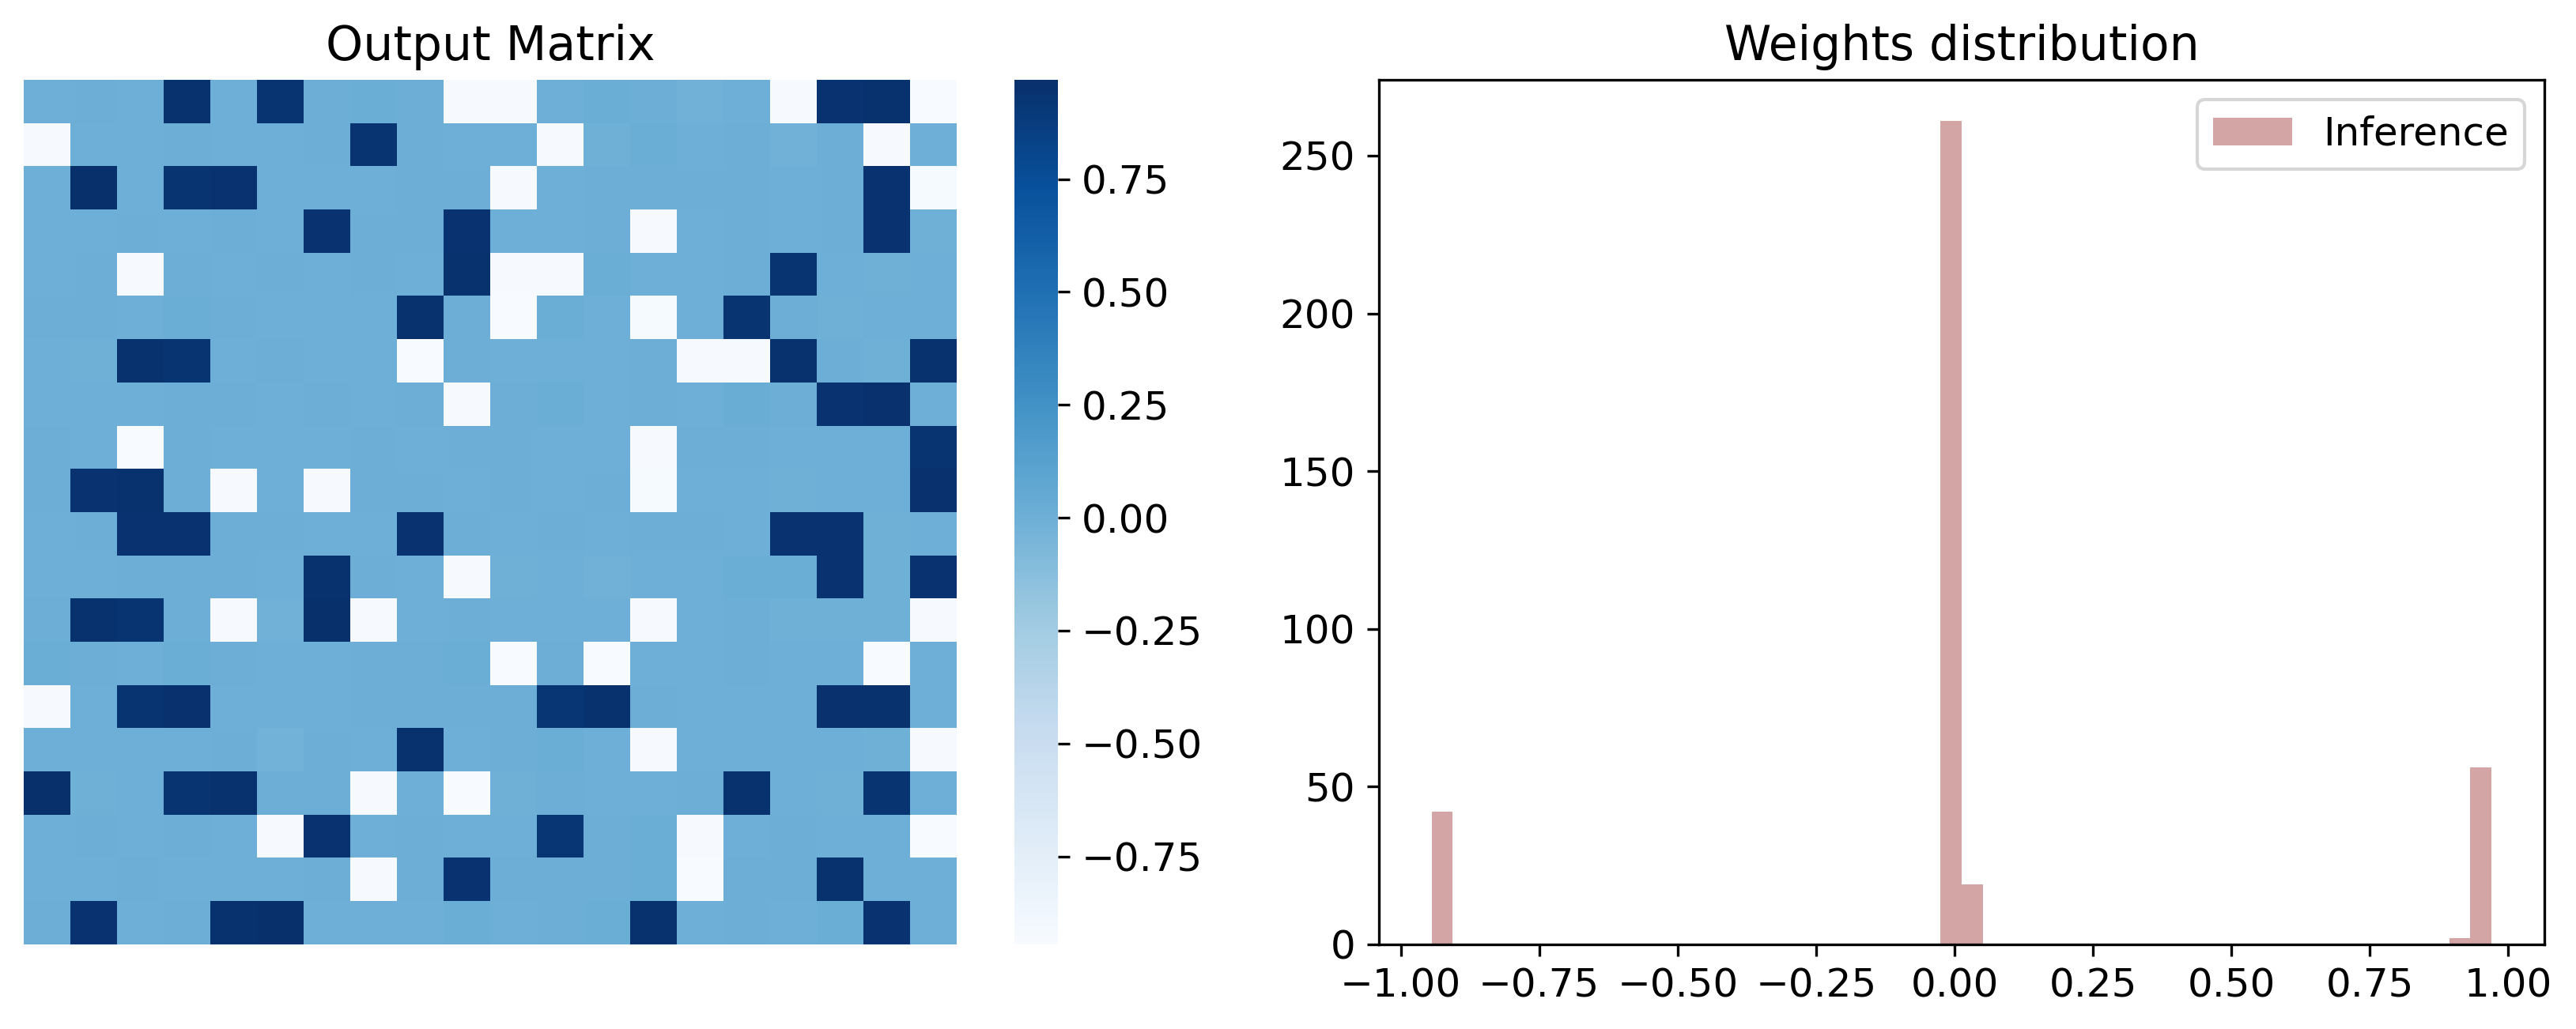

In [267]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
snb.heatmap(Stru, cmap='Blues', ax=ax1)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.legend()
ax2.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_results.pdf')

plt.tight_layout()
plt.show()

In [268]:
bistru = Stru.copy()
bistru = np.where(bistru<-0.5,-1,bistru)
bistru = np.where(bistru>0.4,1,bistru)
bistru = np.where((bistru>-0.5) & (bistru<0.4),0,bistru)
print(len(np.where(bistru==1)[0]))
print(len(np.where(bistru==-1)[0]))
print(len(np.where(bistru==0)[0]))

58
42
300


### weights distribution evolute over epochs

In [269]:
weights_chosen = []
epc_chosen = [1,100,300,400,600,1000]
epcstring = ['epoch=1','epoch=100','epoch=300','epoch=400','epoch=600','epoch=1000']
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))

weights_chosen = pd.DataFrame(np.array(weights_chosen),columns=['weights'])
weights_chosen['epoch'] = np.repeat(epcstring,int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

2280
number of edges: 380
(2280, 2)


#### ridgeline plots

380
number of edges: 13
(380, 29)


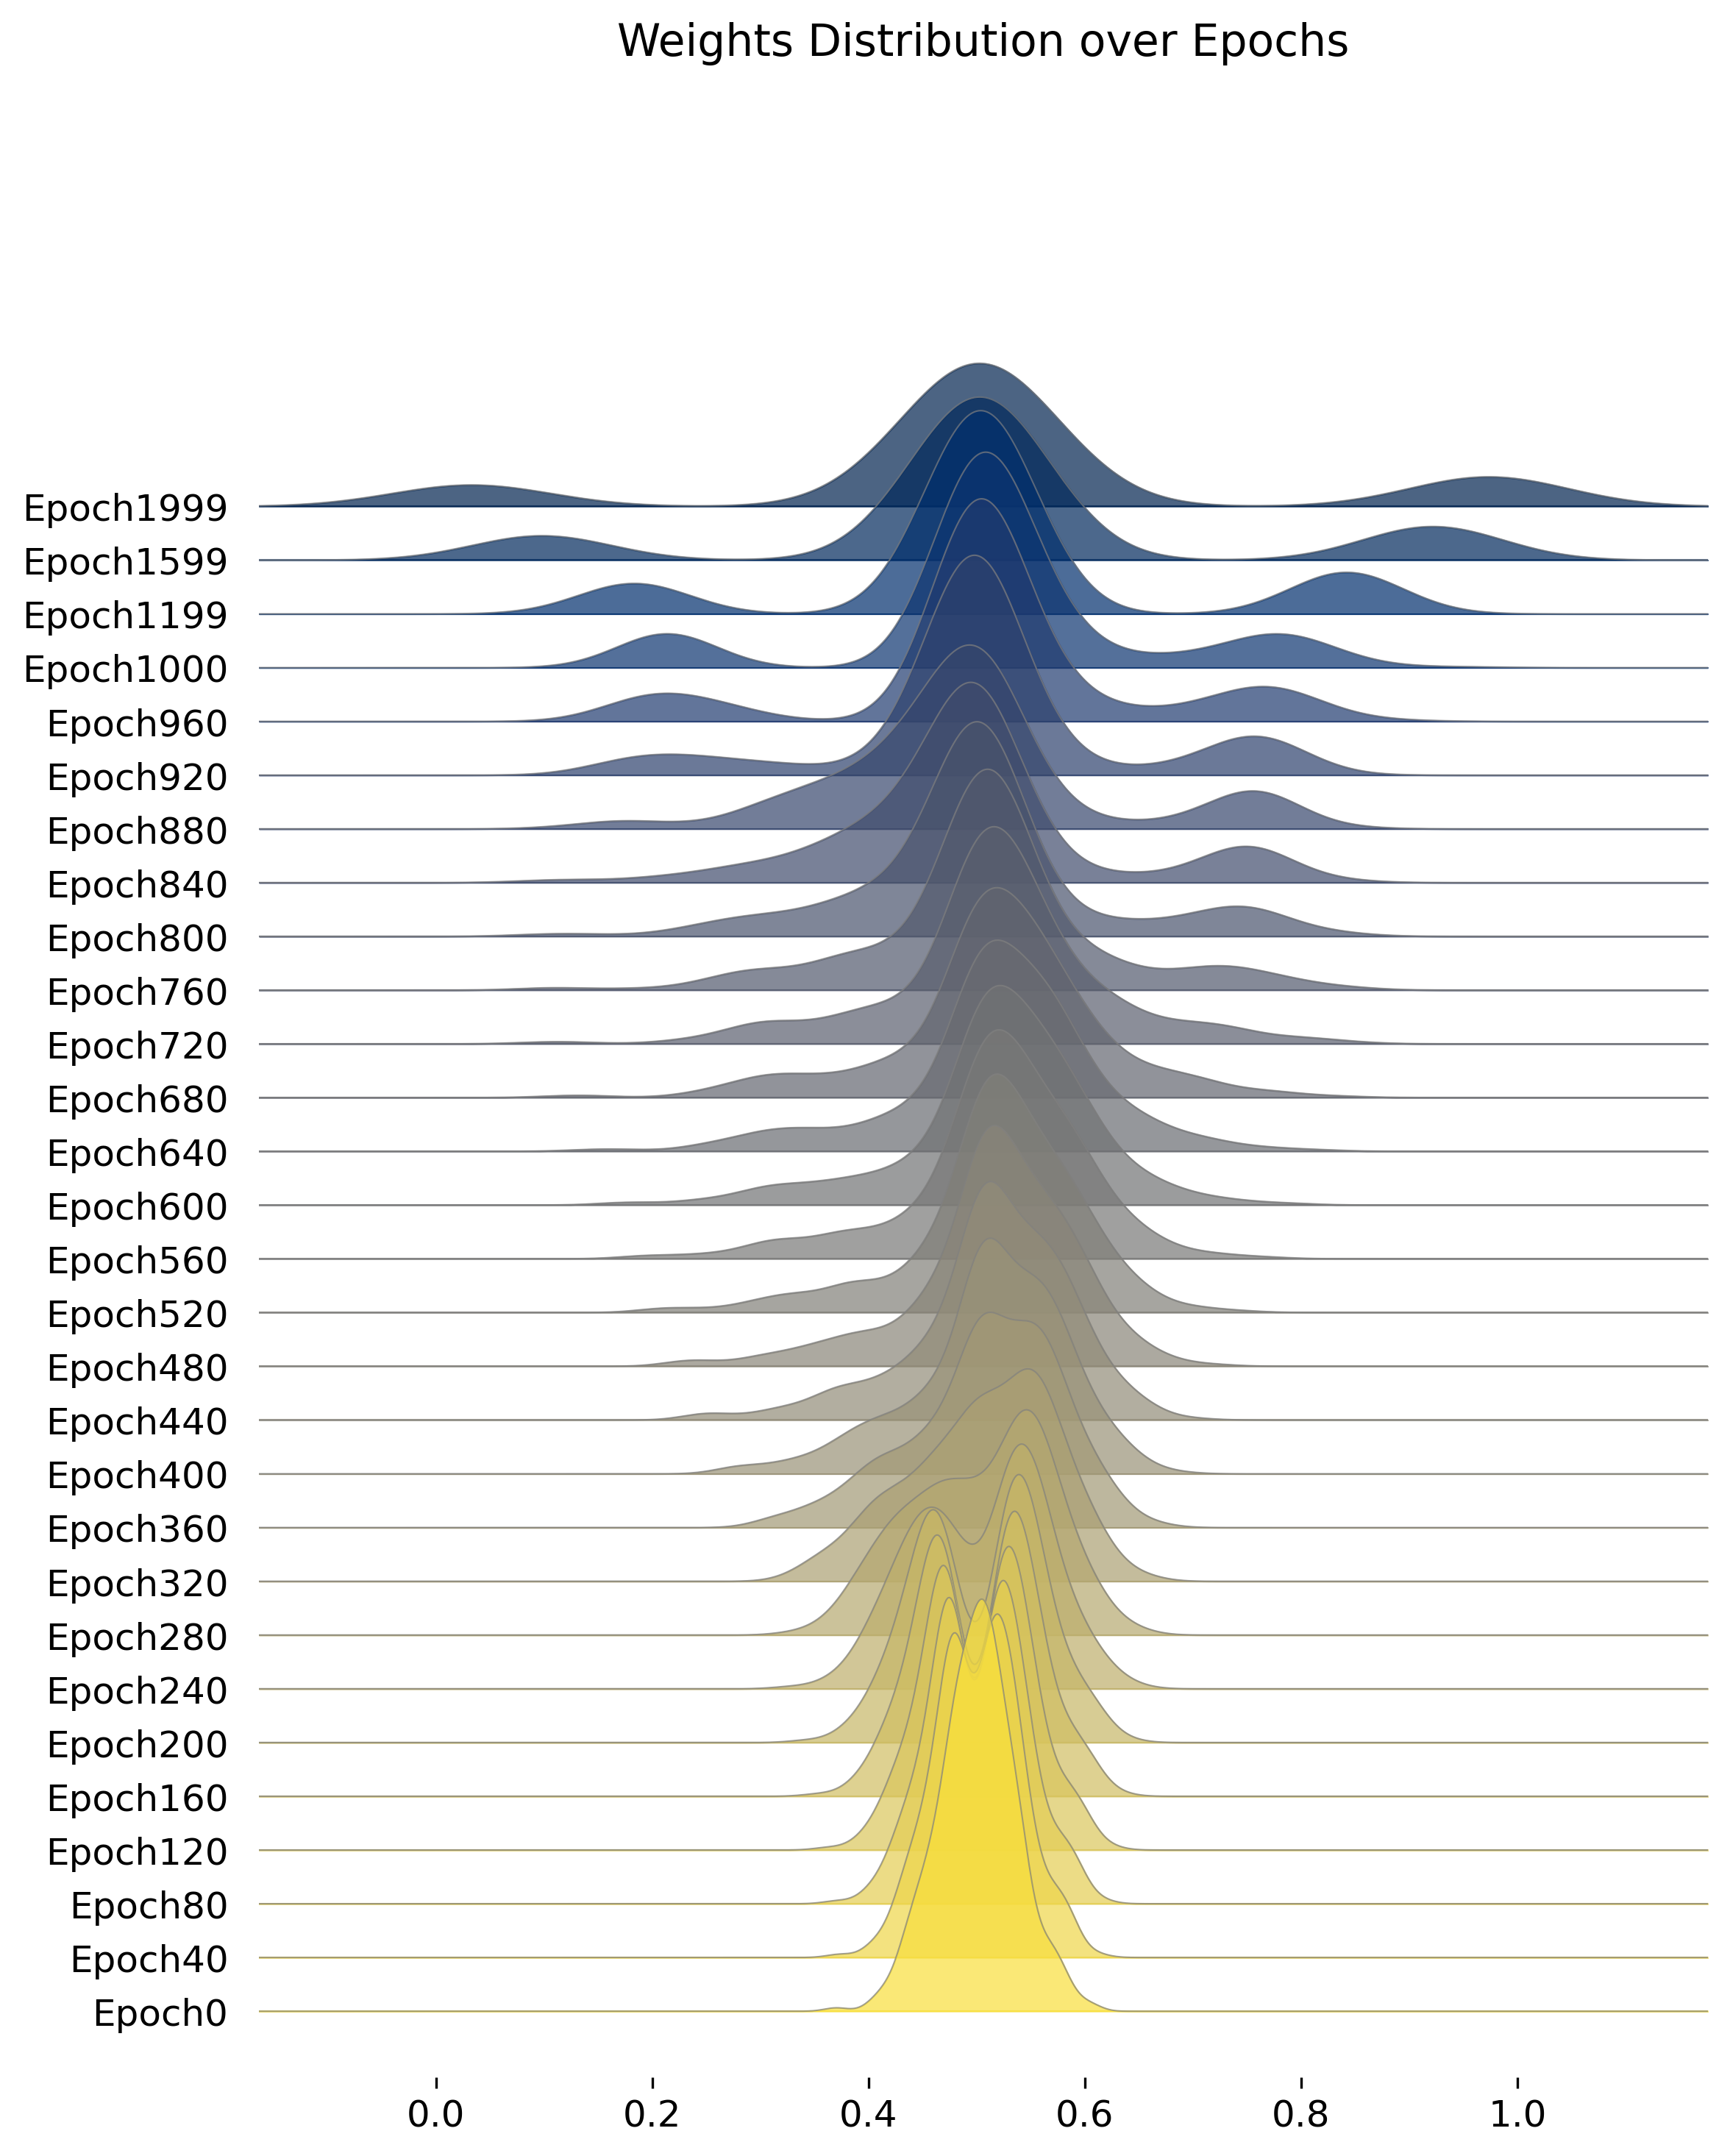

In [271]:
import pandas as pd
import numpy as np
import joypy
import matplotlib.pyplot as plt
nodes_num = 20
edge_num = nodes_num*(nodes_num-1)
weights_chosen = pd.DataFrame()
epc_chosen = np.arange(1,1040,40)
epc_chosen = epc_chosen.tolist()
epc_chosen.append(1200)
epc_chosen.append(1600)
epc_chosen.append(2000)
epc_chosen.reverse()
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen[f'Epoch{e-1}'] = np.array(bestWei).reshape(-1)
    # weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

plt.rcParams['figure.dpi']=300
fig, axes = joypy.joyplot(
    weights_chosen,
    figsize=(8, 10),
    overlap=2.5,
    colormap=plt.cm.cividis,
    title='Weights Distribution over Epochs', 
    linecolor='grey',
    linewidth=0.5,
    alpha=0.7,
)
# plt.savefig('figure2/v3/weights_distribution_over_epochs_less_reverse.pdf')
plt.show()


In [192]:
# Parameter setting
Trial = 1
Dimension = 3
dt = 0.01
Time = 500
nodes_num = 20
batch = args.Batch
Net = 'ER'

path = data_path + 'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)

series = series.reshape(-1, nodes_num, Dimension)
print(series.shape)
goal_data = series[1:-1,:,0:Dimension]
mapping_data = series[0:-2,:,0:Dimension]
print(goal_data.shape==mapping_data.shape)
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

(50000, 20, 3)
True


In [193]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [194]:
def get_edge_index(Adj): #target to source
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

pred_struc = np.abs(bistru)
edge_index = get_edge_index(pred_struc.T)
print('edge_num:', edge_index.shape[1])

edge_num: 100


In [195]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [196]:
pred_edgetype = np.round(Stru)
def get_edge_type(Adj,edge_index):
    edge_type = []
    for i in range(edge_index.shape[1]):
        edge_type.append(Adj[edge_index[1][i]][edge_index[0][i]])# source to target j to i
    edge_type = np.array(edge_type).reshape(-1,1)
    return edge_type

edge_type = get_edge_type(pred_edgetype,edge_index)
edge_type = torch.from_numpy(edge_type).to(device)

In [197]:
trainloader = DataLoader(
    [Data(
        X_train[i],
        edge_index=edge_index,
        y=y_train[i]) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=False
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=int(batch/2),
    shuffle=True
)

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [198]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from tqdm import tqdm
import pandas as pd

hidden = 100
Dyn = Retrain_sign_MP(n_f, msg_dim, dim, dt, edge_type, aggr=aggr, hidden=hidden).to(device)
Dyn = torch.compile(Dyn)
edge_index = edge_index.to(device)
init_lr = 5e-4
opt = torch.optim.AdamW(Dyn.parameters(), lr=init_lr, weight_decay=1e-6)
total_epochs = 100
batch_per_epoch = 1000
sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)


### Use inferred structure train the MLP (dynamics) again

In [199]:
recorded_models = []
lose_over_epochs = []
valoss_over_epochs = []
for epoch in tqdm(range(total_epochs)):
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            ginput = ginput.to(device)
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            loss = Dyn.loss(ginput,square=True)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    Dyn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                ginput = ginput.to(device)
                if j>= batch_per_epoch:
                    break
                loss = Dyn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1

    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    lose_over_epochs.append(cur_loss)
    valoss_over_epochs.append(cur_valid_loss)
    
    from copy import deepcopy as copy
    recorded_models.append(copy(Dyn.state_dict()))

torch.save(recorded_models, save_path+f'recorded_models.pt')

  1%|          | 1/100 [00:12<20:31, 12.44s/it]

0.02454891078615672
0.003933571252067295


  2%|▏         | 2/100 [00:22<18:26, 11.30s/it]

0.009032356627471988
0.00330537287313605


  3%|▎         | 3/100 [00:34<18:14, 11.28s/it]

0.007290020491448012
0.004194665548072149


  4%|▍         | 4/100 [00:45<18:03, 11.28s/it]

0.006114668860869427
0.005757554549546849


  5%|▌         | 5/100 [00:58<18:56, 11.96s/it]

0.005068690669267287
0.006019208449499869


  6%|▌         | 6/100 [01:08<17:48, 11.37s/it]

0.0039606988609218585
0.005706595095712515


  7%|▋         | 7/100 [01:18<16:57, 10.94s/it]

0.0029012702376700734
0.00626514596254905


  8%|▊         | 8/100 [01:30<17:14, 11.24s/it]

0.0020181647932052925
0.005946782412646629


  9%|▉         | 9/100 [01:42<17:23, 11.47s/it]

0.0013965609914263332
0.0031167505755793673


 10%|█         | 10/100 [01:54<17:17, 11.53s/it]

0.0010308098968240572
0.0018893714105480965


 11%|█         | 11/100 [02:08<18:06, 12.21s/it]

0.0008107144629013876
0.0015568674617732416


 12%|█▏        | 12/100 [02:20<18:01, 12.29s/it]

0.0006633032842810314
0.0017967730660899146


 13%|█▎        | 13/100 [02:31<16:57, 11.70s/it]

0.0005537044173339944
0.001737768806872272


 14%|█▍        | 14/100 [02:41<16:14, 11.33s/it]

0.0004713452161123982
0.00127035260648671


 15%|█▌        | 15/100 [02:51<15:20, 10.83s/it]

0.00041058340399869524
0.0012368335793749843


 16%|█▌        | 16/100 [03:04<16:09, 11.55s/it]

0.0003672758058949296
0.0012360171790460597


 17%|█▋        | 17/100 [03:18<16:53, 12.21s/it]

0.0003229193568450754
0.0013289099146554717


 18%|█▊        | 18/100 [03:29<16:21, 11.97s/it]

0.0002805467599347389
0.001190591330440079


 19%|█▉        | 19/100 [03:39<15:29, 11.47s/it]

0.00024730207003663174
0.001006122652537275


 20%|██        | 20/100 [03:50<14:48, 11.11s/it]

0.0002127482988135822
0.0008647650389829142


 21%|██        | 21/100 [04:00<14:17, 10.85s/it]

0.0001882990998657342
0.0008339171905997822


 22%|██▏       | 22/100 [04:10<13:52, 10.67s/it]

0.00016430637730933733
0.0007691023429198178


 23%|██▎       | 23/100 [04:20<13:18, 10.36s/it]

0.00014413427685035576
0.0007065946985161419


 24%|██▍       | 24/100 [04:29<12:49, 10.13s/it]

0.00013008512253099758
0.0007251488931690489


 25%|██▌       | 25/100 [04:39<12:26,  9.95s/it]

0.0001153294255691416
0.000790462954338111


 26%|██▌       | 26/100 [04:49<12:11,  9.88s/it]

0.00010562390437125418
0.0006740907449813388


 27%|██▋       | 27/100 [04:58<11:58,  9.84s/it]

9.686642605306023e-05
0.0006420684230766968


 28%|██▊       | 28/100 [05:08<11:47,  9.83s/it]

8.984145713454416e-05
0.0007064798626246172


 29%|██▉       | 29/100 [05:19<11:49,  9.99s/it]

8.59839889082328e-05
0.0005805840631655808


 30%|███       | 30/100 [05:28<11:35,  9.94s/it]

7.483595531750948e-05
0.0005051146466354133


 31%|███       | 31/100 [05:38<11:28,  9.97s/it]

6.8576936084319e-05
0.0004647357615422204


 32%|███▏      | 32/100 [05:49<11:21, 10.02s/it]

6.311489944649032e-05
0.0003957604411483282


 33%|███▎      | 33/100 [05:58<11:08,  9.98s/it]

5.813045295867988e-05
0.00033724114725609816


 34%|███▍      | 34/100 [06:08<10:53,  9.90s/it]

5.141836763225855e-05
0.00033880941237030503


 35%|███▌      | 35/100 [06:18<10:48,  9.97s/it]

4.761039770619794e-05
0.0003130670863580962


 36%|███▌      | 36/100 [06:28<10:36,  9.95s/it]

4.33364643249719e-05
0.00026956120025533616


 37%|███▋      | 37/100 [06:38<10:31, 10.03s/it]

3.939389605423108e-05
0.00025174160512000726


 38%|███▊      | 38/100 [06:48<10:20, 10.01s/it]

3.5320345293593896e-05
0.00022146154580719152


 39%|███▉      | 39/100 [06:58<10:08,  9.98s/it]

3.247424054854261e-05
0.00022534881516289714


 40%|████      | 40/100 [07:11<10:41, 10.69s/it]

2.9198390942882166e-05
0.00022286672878572394


 41%|████      | 41/100 [07:22<10:50, 11.02s/it]

2.6747352865062812e-05
0.0002065392150968791


 42%|████▏     | 42/100 [07:35<11:11, 11.57s/it]

2.527081498699887e-05
0.00022489536492100308


 43%|████▎     | 43/100 [07:48<11:21, 11.95s/it]

2.269066252083881e-05
0.0002121673115017159


 44%|████▍     | 44/100 [08:01<11:18, 12.12s/it]

2.2607934748235082e-05
0.00021804486840636402


 45%|████▌     | 45/100 [08:11<10:41, 11.66s/it]

1.975932836453777e-05
0.00019915420019842291


 46%|████▌     | 46/100 [08:23<10:38, 11.83s/it]

1.8765598207019287e-05
0.00019302290445270335


 47%|████▋     | 47/100 [08:35<10:22, 11.75s/it]

1.8396538212307456e-05
0.00018149701672333498


 48%|████▊     | 48/100 [08:46<10:03, 11.60s/it]

1.7144360930878305e-05
0.0001541696730098279


 49%|████▉     | 49/100 [08:58<09:55, 11.68s/it]

1.600660214443794e-05
0.00013605085071733837


 50%|█████     | 50/100 [09:08<09:19, 11.19s/it]

1.4923142594415897e-05
0.00012781801630746574


 51%|█████     | 51/100 [09:18<08:45, 10.72s/it]

1.5149102386560012e-05
0.00010363710298231176


 52%|█████▏    | 52/100 [09:29<08:40, 10.83s/it]

1.295494433182159e-05
9.67320361423771e-05


 53%|█████▎    | 53/100 [09:42<08:57, 11.45s/it]

1.2476155620904957e-05
8.24098979413709e-05


 54%|█████▍    | 54/100 [09:54<08:56, 11.65s/it]

1.1350101794530018e-05
8.126120208715969e-05


 55%|█████▌    | 55/100 [10:04<08:29, 11.32s/it]

1.1138331432922428e-05
6.50093770697568e-05


 56%|█████▌    | 56/100 [10:14<08:00, 10.91s/it]

1.0558595202864071e-05
6.156390262556332e-05


 57%|█████▋    | 57/100 [10:26<07:57, 11.10s/it]

9.664427206061107e-06
5.7461273175422113e-05


 58%|█████▊    | 58/100 [10:37<07:51, 11.24s/it]

9.651965034809494e-06
4.810916101996271e-05


 59%|█████▉    | 59/100 [10:48<07:36, 11.14s/it]

8.39225591429857e-06
4.254488960874477e-05


 60%|██████    | 60/100 [11:01<07:40, 11.52s/it]

8.49498753834614e-06
3.6262680144844694e-05


 61%|██████    | 61/100 [11:13<07:34, 11.64s/it]

7.426478476537368e-06
3.087937842537183e-05


 62%|██████▏   | 62/100 [11:24<07:22, 11.64s/it]

7.468943362318065e-06
2.3876809148067268e-05


 63%|██████▎   | 63/100 [11:35<07:03, 11.44s/it]

6.843724475122428e-06
1.9277658287927646e-05


 64%|██████▍   | 64/100 [11:45<06:34, 10.97s/it]

6.562595174747368e-06
1.5477219469577255e-05


 65%|██████▌   | 65/100 [11:55<06:16, 10.75s/it]

6.106365590452533e-06
1.3156847005295597e-05


 66%|██████▌   | 66/100 [12:05<05:57, 10.51s/it]

5.959627542279426e-06
1.2139443059789447e-05


 67%|██████▋   | 67/100 [12:16<05:49, 10.59s/it]

5.587350750346098e-06
7.650045832122363e-06


 68%|██████▊   | 68/100 [12:26<05:29, 10.30s/it]

5.23840575303087e-06
6.60717153461285e-06


 69%|██████▉   | 69/100 [12:36<05:20, 10.32s/it]

4.970892459225249e-06
5.659823477004854e-06


 70%|███████   | 70/100 [12:47<05:18, 10.62s/it]

4.5082509337820125e-06
4.896992508221574e-06


 71%|███████   | 71/100 [12:58<05:05, 10.54s/it]

4.313834166408827e-06
4.715097450605563e-06


 72%|███████▏  | 72/100 [13:11<05:18, 11.36s/it]

3.97206787625241e-06
4.772470942446087e-06


 73%|███████▎  | 73/100 [13:24<05:19, 11.83s/it]

3.7810609068810946e-06
4.785622596044914e-06


 74%|███████▍  | 74/100 [13:34<04:54, 11.32s/it]

3.5554885024388436e-06
3.966739774956458e-06


 75%|███████▌  | 75/100 [13:45<04:38, 11.15s/it]

3.3832183844865402e-06
3.216339287285482e-06


 76%|███████▌  | 76/100 [13:56<04:26, 11.08s/it]

3.32633577138404e-06
3.955033689060719e-06


 77%|███████▋  | 77/100 [14:06<04:09, 10.83s/it]

3.0710623509902215e-06
2.958934101142077e-06


 78%|███████▊  | 78/100 [14:16<03:54, 10.67s/it]

2.8379164934849314e-06
2.2557772391778276e-06


 79%|███████▉  | 79/100 [14:26<03:39, 10.47s/it]

2.755524800743715e-06
2.5445835429506725e-06


 80%|████████  | 80/100 [14:36<03:25, 10.29s/it]

2.6005249928899787e-06
1.8159609534168033e-06


 81%|████████  | 81/100 [14:46<03:13, 10.17s/it]

2.4105206462302767e-06
1.7371030243782174e-06


 82%|████████▏ | 82/100 [14:56<03:02, 10.16s/it]

2.2875743826058763e-06
1.971069309676375e-06


 83%|████████▎ | 83/100 [15:07<02:56, 10.39s/it]

2.196485962242464e-06
1.9962439944216388e-06


 84%|████████▍ | 84/100 [15:20<02:56, 11.02s/it]

2.0728579814590207e-06
1.5683625082974604e-06


 85%|████████▌ | 85/100 [15:31<02:46, 11.13s/it]

2.0067150327427823e-06
1.4349440966146745e-06


 86%|████████▌ | 86/100 [15:42<02:36, 11.18s/it]

1.944292502932831e-06
1.51512727023795e-06


 87%|████████▋ | 87/100 [15:54<02:25, 11.20s/it]

1.870867412272872e-06
1.1844403766671026e-06


 88%|████████▊ | 88/100 [16:05<02:14, 11.22s/it]

1.8362519829860982e-06
1.3219780568103315e-06


 89%|████████▉ | 89/100 [16:16<02:03, 11.23s/it]

1.7672300640461845e-06
1.3748665039452304e-06


 90%|█████████ | 90/100 [16:26<01:48, 10.84s/it]

1.7427458195607576e-06
1.1973620501632185e-06


 91%|█████████ | 91/100 [16:36<01:34, 10.55s/it]

1.7231797912857268e-06
1.2189226767719714e-06


 92%|█████████▏| 92/100 [16:46<01:22, 10.35s/it]

1.7247756837390275e-06
1.2638248650759695e-06


 93%|█████████▎| 93/100 [16:58<01:16, 10.98s/it]

1.7674361848826661e-06
1.1603059072055805e-06


 94%|█████████▍| 94/100 [17:10<01:06, 11.13s/it]

1.7895268986851858e-06
1.3609938229933132e-06


 95%|█████████▌| 95/100 [17:21<00:56, 11.28s/it]

1.8811627420754436e-06
2.1135764906213546e-06


 96%|█████████▌| 96/100 [17:33<00:45, 11.29s/it]

2.007678487321913e-06
1.1886280409929234e-06


 97%|█████████▋| 97/100 [17:43<00:33, 11.04s/it]

1.844544063967203e-06
1.0894144591311596e-06


 98%|█████████▊| 98/100 [17:54<00:22, 11.03s/it]

1.7445593596465935e-06
1.1689410535324433e-06


 99%|█████████▉| 99/100 [18:07<00:11, 11.67s/it]

1.6863349470548836e-06
9.337138326821857e-07


100%|██████████| 100/100 [18:20<00:00, 11.01s/it]

1.6341188063393472e-06
9.128686741303079e-07


### Load the recorded model

In [ ]:
device = torch.device('cpu')
# recorded_models = torch.load(save_path+f'recorded_models.pt')
Dyn = Retrain_sign_MP(n_f, msg_dim, dim, dt, edge_type, aggr=aggr, hidden=hidden).to(device)
Dyn = torch.compile(Dyn)
Dyn.load_state_dict(recorded_models[-1])

/tmp/ipykernel_104768/2836524844.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recorded_models = torch.load(save_path+f'recorded_models.pt')


<All keys matched successfully>

In [201]:
np.random.seed(20)
test_idxes = np.random.randint(0, len(X_test), 100)

X_test = X_test.to(device)
y_test = y_test.to(device)

newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [206]:
import numpy as onp
import pandas as pd

def get_messages(ogn, dim, msg_dim, loader):

    def get_message_info(tmp):
        tmp = tmp.to(device)
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()# tmp has shape [E, 2 * in_channels]
        Len = int(s1.shape[0])/int(edge_type.shape[0])
        T = edge_type.repeat(int(Len),1)
        
        Tmp.cpu()
        w_type1 = torch.where(T>0,T,0)
        w_type2 = torch.where(T<0,-T,0)
        tmpT = torch.cat([Tmp,T],dim=1)
        tmpT = tmpT.to(torch.float32)
        
        m12_type1 = ogn.msg_fnc_type1(Tmp)
        m12_type2 = ogn.msg_fnc_type2(Tmp)
        m12 = m12_type1*w_type1+m12_type2*w_type2

        all_messages = torch.cat((
            tmpT,m12_type1, m12_type2,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [208]:
def get_selfDynamics(ogn, dim, loader):
    def get_selfDynamics_info(tmp):
        tmp = tmp.to(device)
        ogn.cpu()
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(loader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [209]:
edge_index = edge_index.to(device)
edge_type = edge_type.to(device)

In [210]:
msgs = get_messages(Dyn, dim=Dimension, msg_dim=1, loader=newtestloader)
selfdyn = get_selfDynamics(Dyn,dim=Dimension, loader=newtestloader)

In [211]:
# x1 (x_i) is target, x2 (x_j) is source 
msg_type2 = msgs[msgs['T'] < -0.5] 
x_i = msg_type2['x1'].values
x_j = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values

if np.sum(G_type22 > 0):
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are excitary.")
else:
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are inhibitory.")

msg_type1 = msgs[msgs['T'] > 0.5 ]
x_i = msg_type1['x1'].values
x_j = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
if np.sum(G_type11 < 0):
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
    print("G_type11 values are inhibitory.")
else:
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitary
    print("G_type11 values are excitary.")

G_type22 values are excitary.
G_type11 values are inhibitory.


In [212]:
np.random.seed(2024)
num = 500
# index = np.random.randint(0, 40000, num)
index = np.arange(0, num,1)

Text(0, 0.5, 'Inferred type2 interactions')

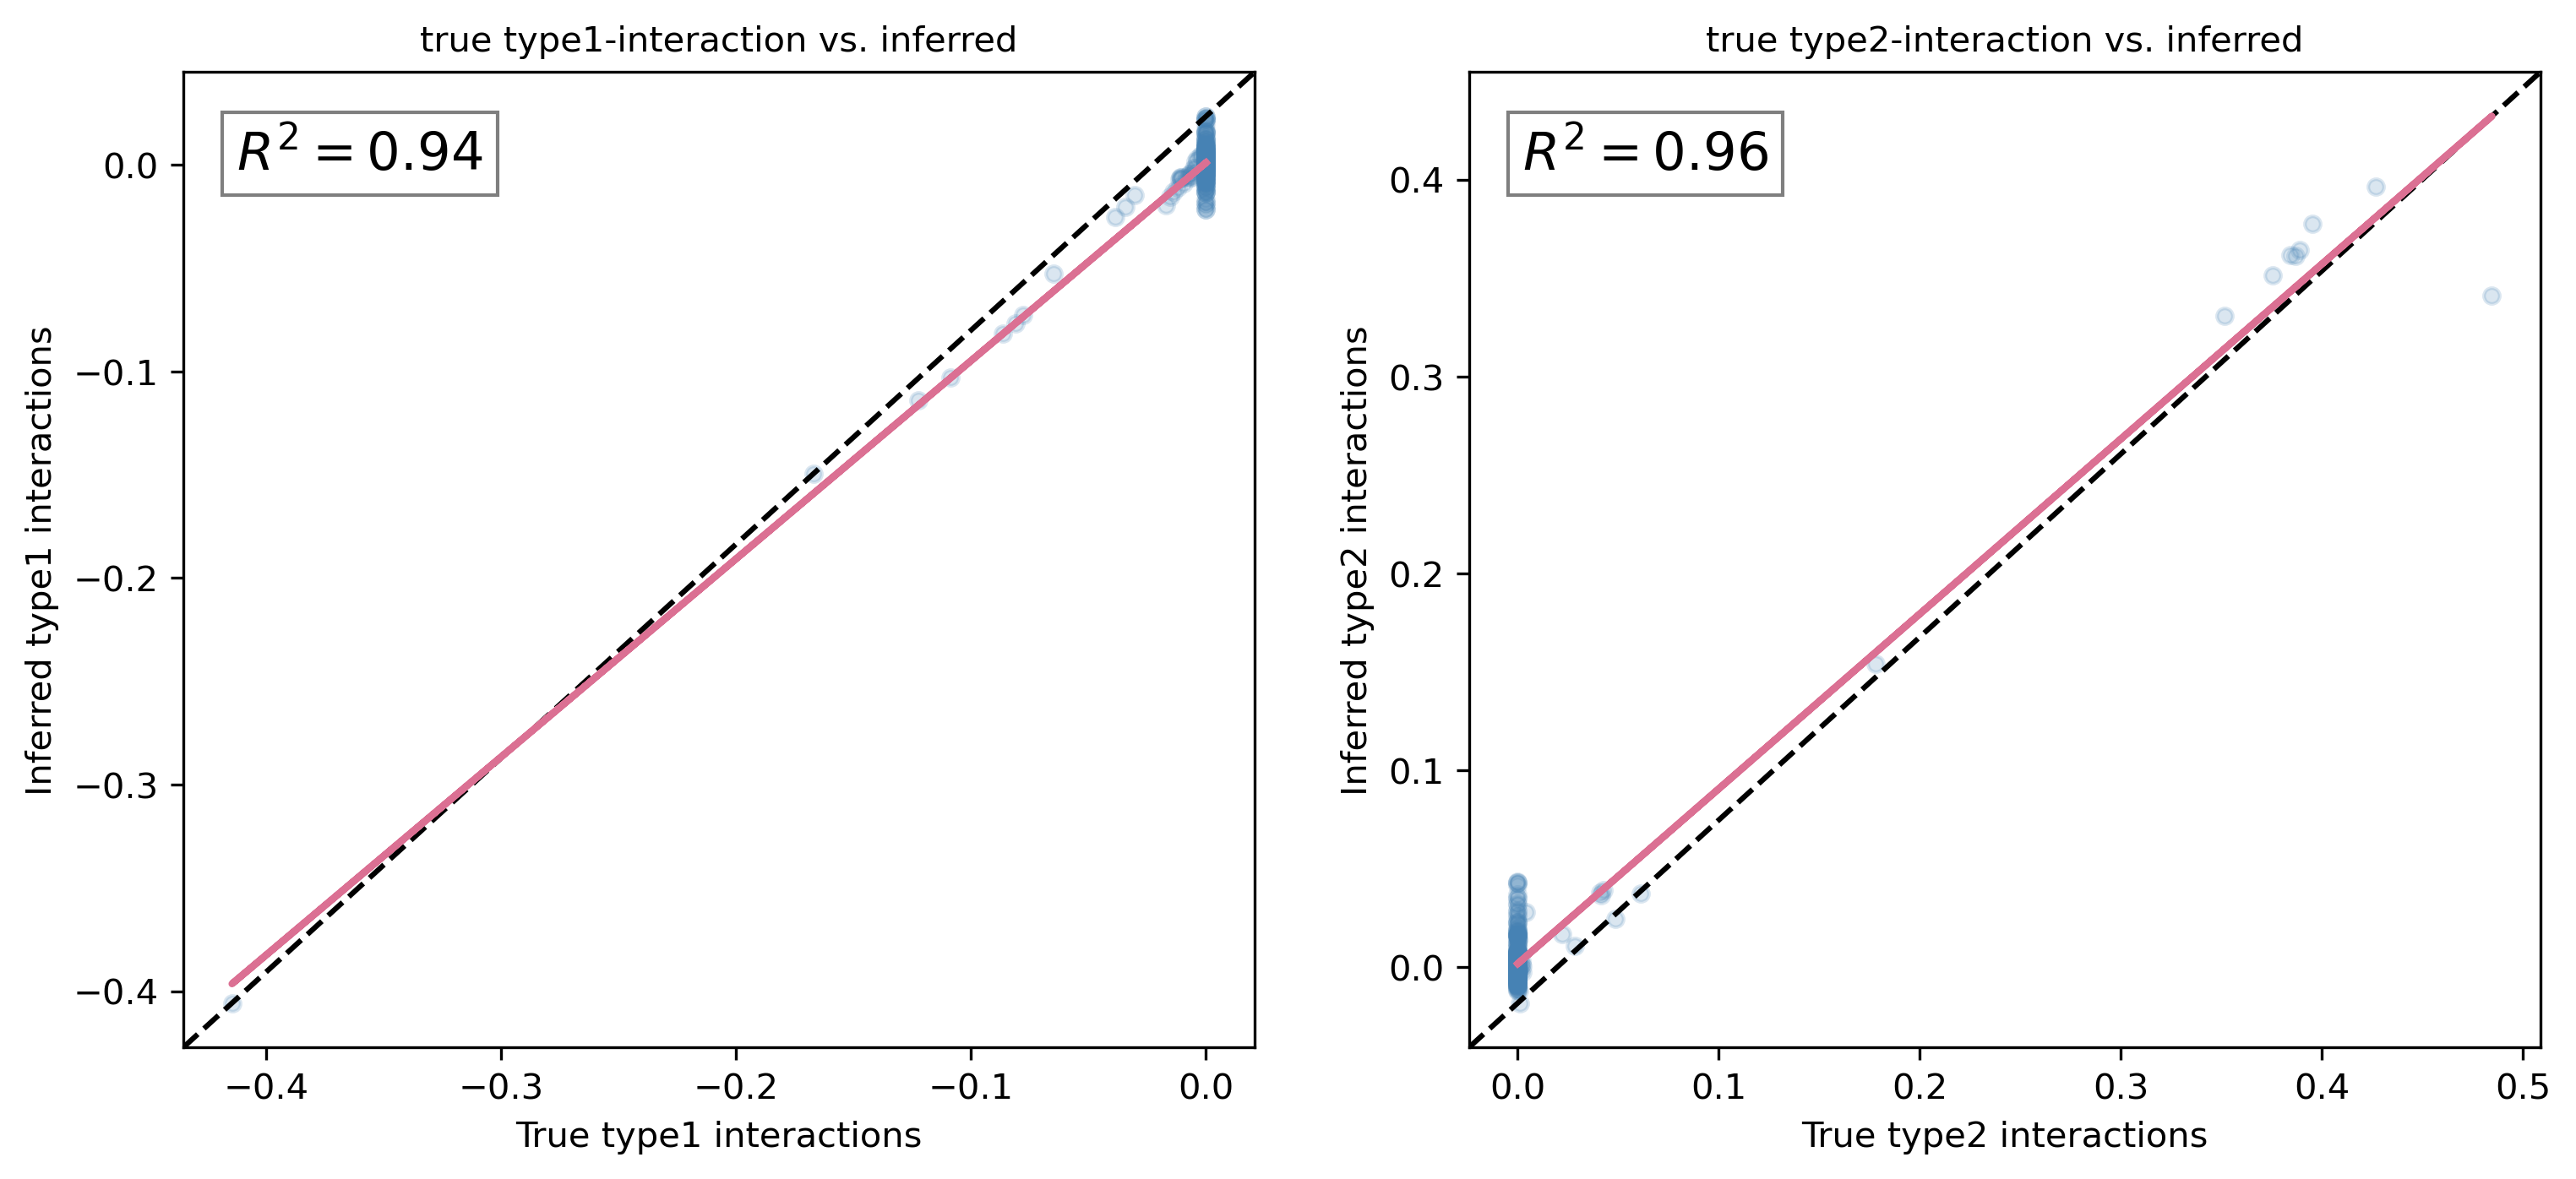

In [213]:
G_type2 = G_type22[index]
G_type1 = G_type11[index]
coup_value_inh = coup_value_inh[index]
coup_value_exc = coup_value_exc[index]
import matplotlib as mpl
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1)
plt.title("true type1-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(coup_value_inh,G_type1,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(coup_value_inh,G_type1,1)
fx = np.poly1d(parameterx)
ax1.plot(coup_value_inh,fx(coup_value_inh),c='palevioletred',lw=2)
corrx = np.corrcoef(coup_value_inh,G_type1)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True type1 interactions")
plt.ylabel("Inferred type1 interactions")

ax2 = fig.add_subplot(1,2,2)
plt.title("true type2-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(coup_value_exc,G_type2,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(coup_value_exc,G_type2,1)
fy = np.poly1d(parametery)
ax2.plot(coup_value_exc,fy(coup_value_exc),c='palevioletred',lw=2)
corry = np.corrcoef(coup_value_exc,G_type2)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True type2 interactions")
plt.ylabel("Inferred type2 interactions")
# plt.savefig('retrain_inference_results_lr5e-4.pdf')

In [214]:
import pandas as pd
coup_value_type1 = np.array(coup_value_inh)
G_type1 = np.array(G_type1)
type1 = pd.concat([pd.DataFrame(coup_value_type1),pd.DataFrame(G_type1)],axis=1)
coup_value_type2 = np.array(coup_value_exc)
G_type2 = np.array(G_type2)
type2 = pd.concat([pd.DataFrame(coup_value_type2),pd.DataFrame(G_type2)],axis=1)

interact = pd.concat([type1,type2],axis=0)
interact.columns = ['True','Inferred']
interact['Interaction'] = ['Type1-dyn']*num+['Type2-dyn']*num

In [180]:
# interact.to_csv('retrain_interact_results.csv',index=False)

1.0


Text(0.65, 0.05, '$R^2=1.00$')

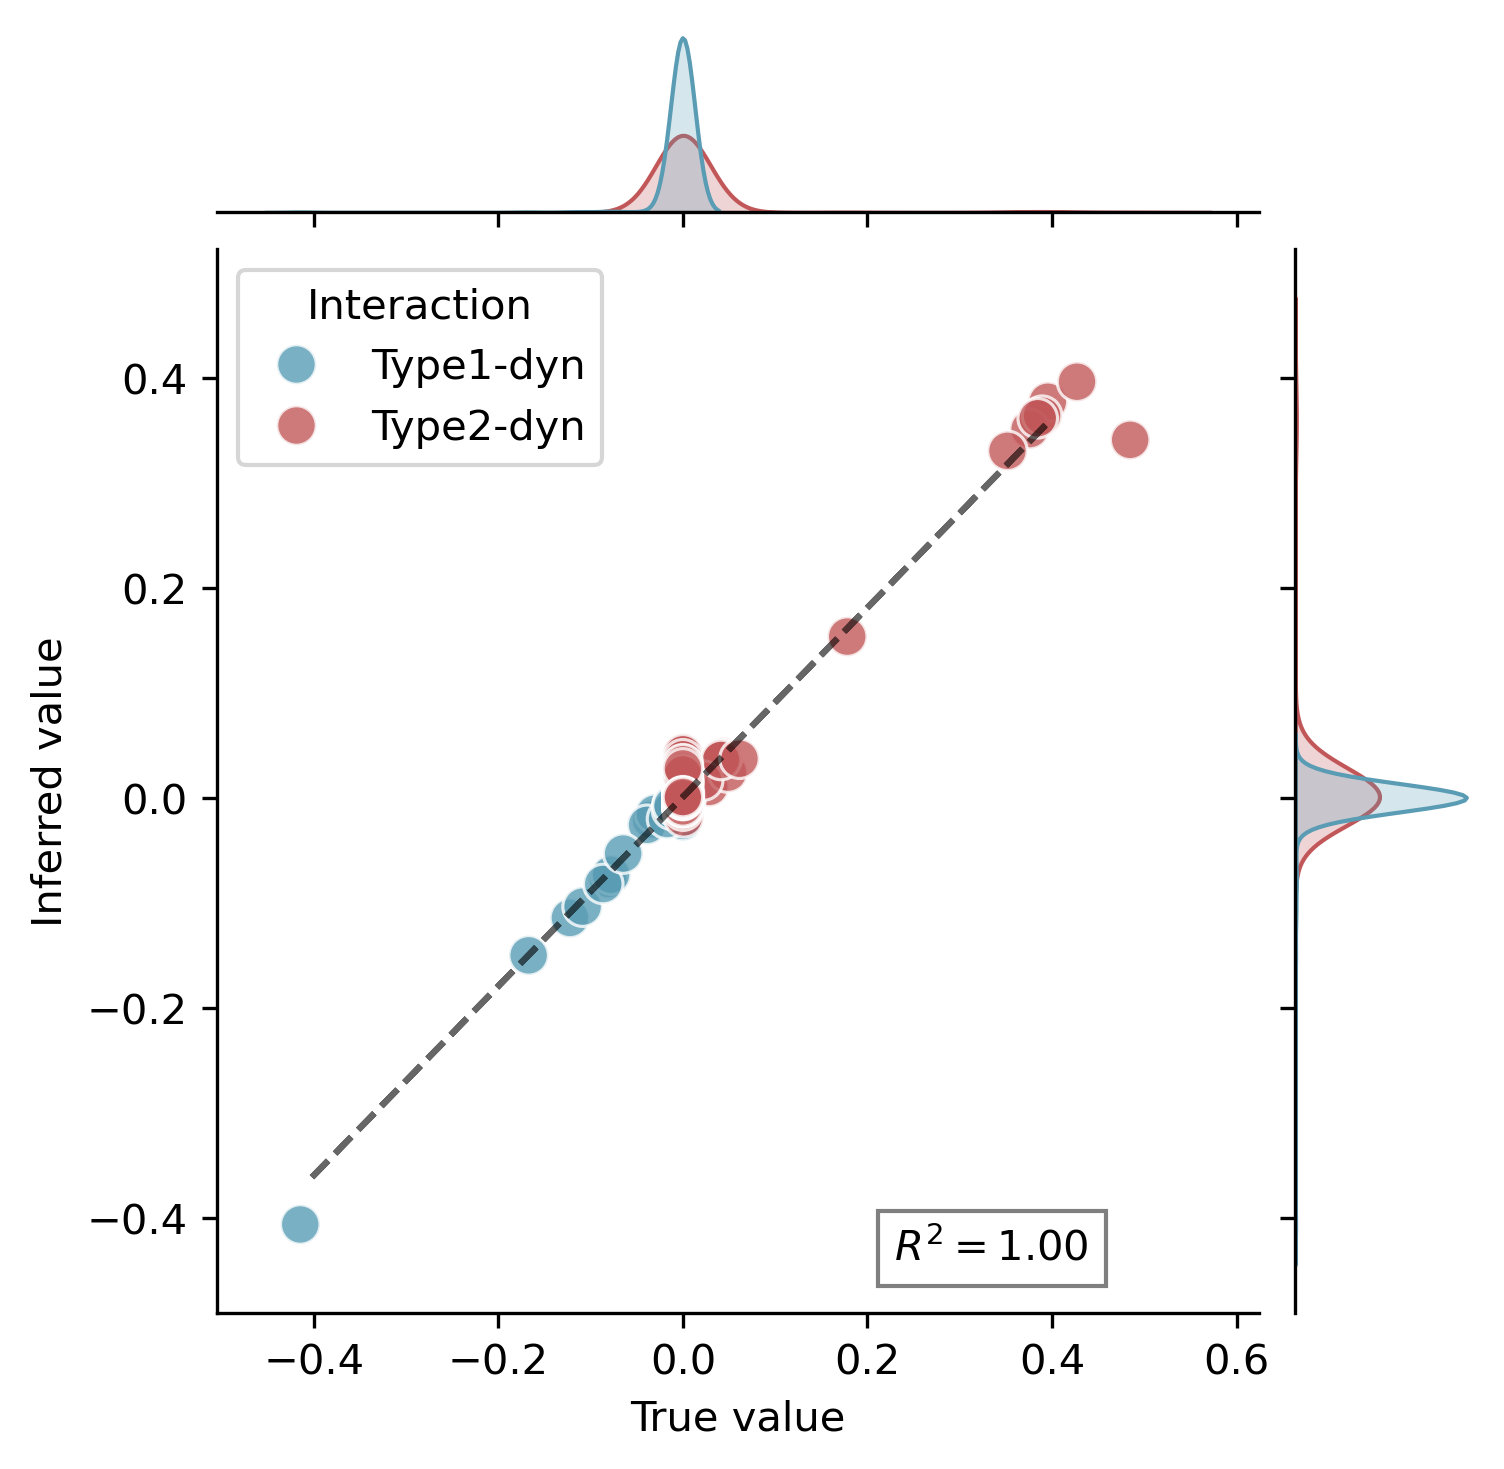

In [215]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
# figure = plt.figure(figsize=(10,10))

# palette = ['#8D91C0','#B8ACB9']
palette = ['#599CB4','#C25759']
g = sns.jointplot(data=interact, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Interaction',
                  alpha=0.8, palette = palette,
                  joint_kws=dict(s=90),
                  marginal_kws=dict(bw_adjust=2),
                  height=5,             
)

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(interact['True'].values,interact['Inferred'].values,1)
fx = np.poly1d(parameterx)
g.ax_joint.plot(interact['Inferred'].values,fx(interact['Inferred'].values),alpha = 0.6,c='k',linestyle='--',lw=1.5)
corrx = np.corrcoef(interact['Inferred'].values,fx(interact['Inferred'].values))[0,1]
print(corrx**2)
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# interact['Residual'] = (interact['True'] - interact['Inferred'])
# plt.savefig('figure2/v6/HR20nodes_2type_interaction_fitting_anothercolor.pdf')

### equation inference

In [216]:
from utils.Interaction_func import *
from utils.Self_func import *
msg_type2 = msgs[msgs['T'] < -0.5]
xi = msg_type2['x1'].values
xj = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values
# coup_value_type22 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
goal = G_type22.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [217]:
print(EleMatrix.columns)

Index(['xj', 'xixj', 'xjMinusxi', 'sinxj', 'sinxixj', 'sinxjMinusxi',
       'xisinxj', 'expxj', 'expxixj', 'expxjMinusxi', 'xiexpxj', 'fracxj',
       'fracxixj', 'fracxjMinusxi', 'xifracxj', 'sigmoidxj', 'sigmoidxixj',
       'sigmoidXjMinusXi', 'xisigmoidxj', 'sigmoidxj101', 'sigmoidxixj101',
       'sigmoidXjMinusXi101', 'xisigmoidxj101', 'tanhxj', 'tanhxixj',
       'tanhxjMinusxi', 'xitanhxj', 'hillxj', 'hillxixj', 'hillxjMinusxi',
       'xihillxj', 'hillxj2', 'hillxixj2', 'hillxjMinusxi2', 'hillxj5',
       'hillxixj5', 'hillxjMinusxi5'],
      dtype='object')


In [218]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [219]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9765478568872566
Best threshold: 0.023


In [220]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
xifracxj               0.000078
hillxixj               0.000114
tanhxj                -0.001225
sigmoidXjMinusXi101   -0.002857
xitanhxj               0.002925
expxjMinusxi          -0.002983
sinxjMinusxi           0.013010
hillxjMinusxi2         0.019416
xisigmoidxj101        -0.112802
sigmoidxj101           0.285383
dtype: float64


In [221]:
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept, n_jobs=-1, max_iter=1000).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [222]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score > 0.95:
        break

sigmoidxj101    0.34881
dtype: float64
0.9400607733109171 0.0001980633270649684 -35811.07972792549 sigmoidxj101
sigmoidxj101      0.284015
xisigmoidxj101   -0.096021
dtype: float64
0.9659249341886047 0.00011259773069097595 -38181.09378396912 xisigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


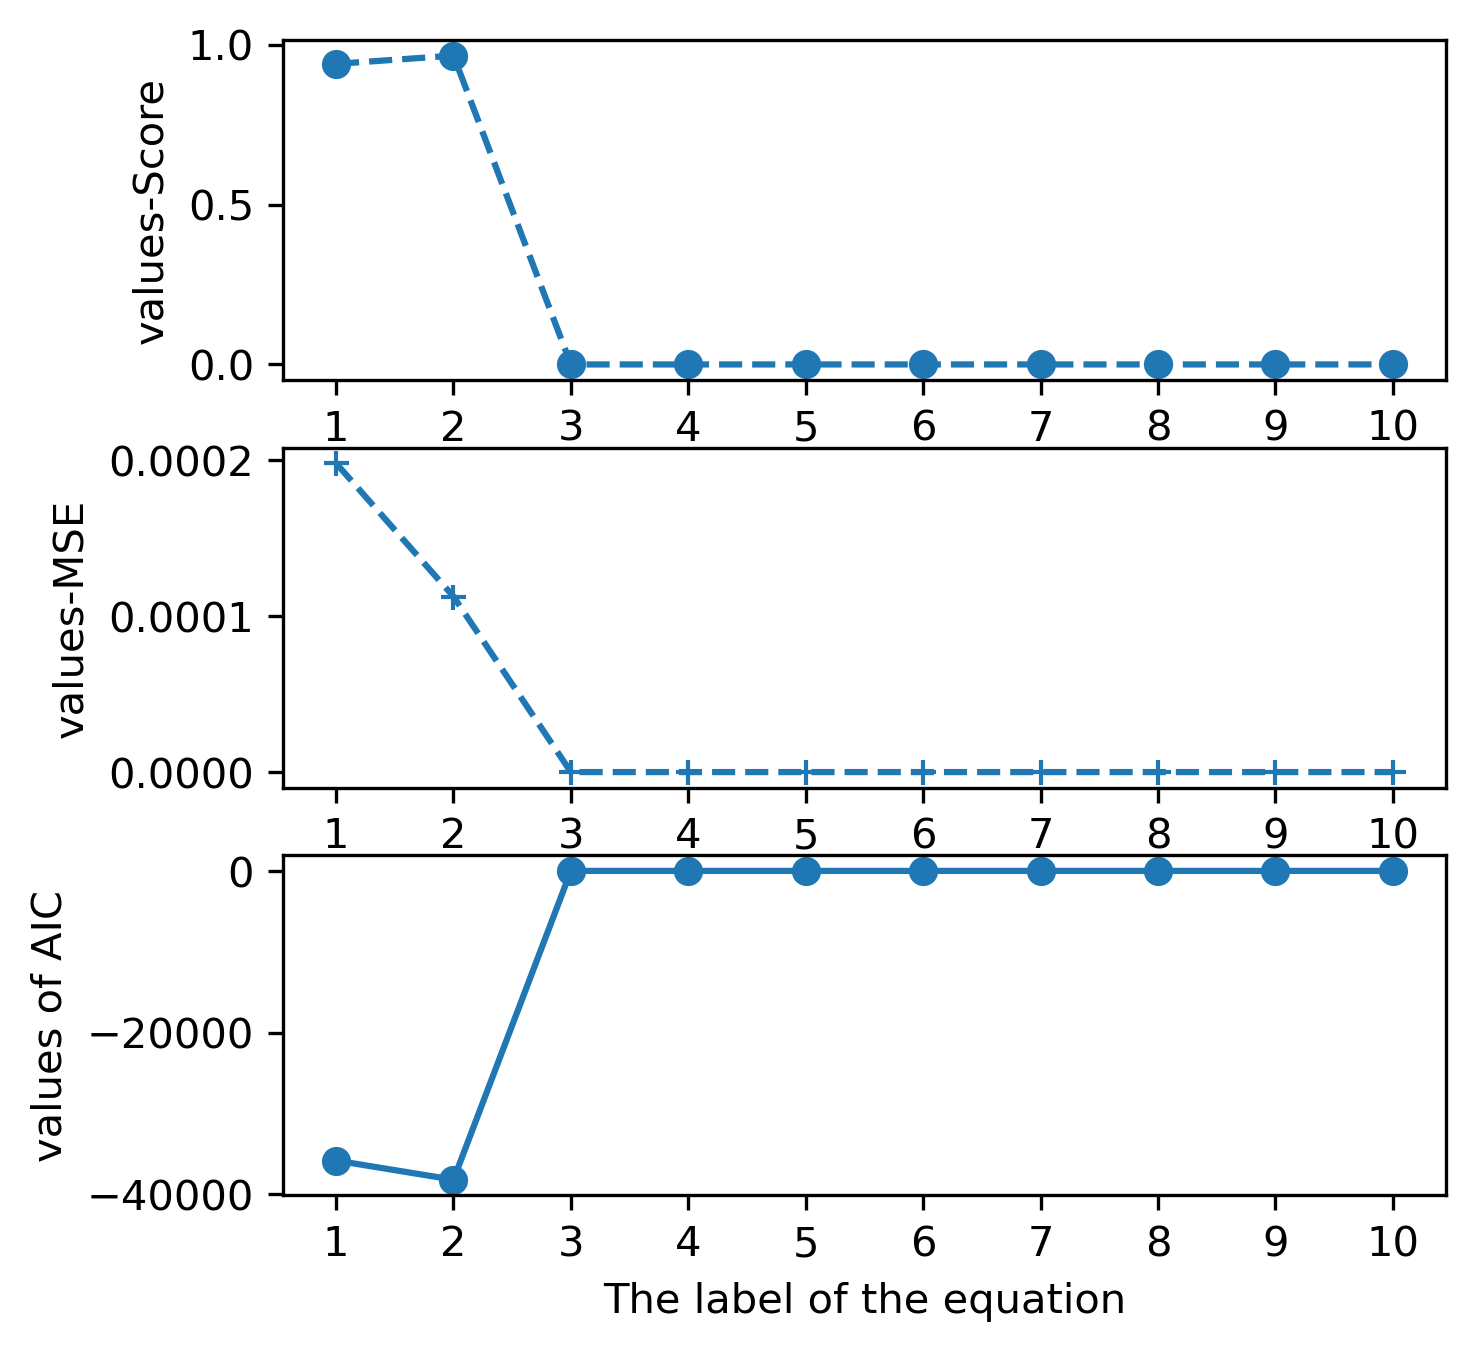

In [223]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_inhibitory_equation.pdf')
plt.show()

In [224]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_inh = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_inh = y['e0']#dim
model_lineari = LinearRegression(fit_intercept=False)
model_lineari.fit(Xfind_inh,yfind_inh)
ai = model_lineari.coef_
ai

array([ 0.28460395, -0.09771325])

In [140]:
# coup_value_type22 = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitatory

In [225]:
t = [0.3,-0.15]
sm = 0
for i in range(len(ai)):
    s = np.abs(ai[i]-t[i])/(np.abs(ai[i])+np.abs(t[i]))
    sm += s
smape_Gi = sm/len(ai)
print(smape_Gi)
smape_Gi = np.mean(np.abs(ai - t) / (np.abs(ai + t)))
smape_Gi

0.11870680359852573


0.11870680359852573

In [226]:
msg_type1 = msgs[msgs['T'] > 0.5]
# msg_type1 = msgs[msgs['T'] >0.5]
xi = msg_type1['x1'].values
xj = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
goal = G_type11.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [227]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [228]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9560346077491458
Best threshold: 0.014


In [229]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
xiexpxj                0.001395
hillxixj2              0.001751
expxj                 -0.002445
expxixj               -0.002520
sinxjMinusxi           0.005718
xisinxj                0.006907
sigmoidXjMinusXi101   -0.008513
hillxjMinusxi2         0.015826
xisigmoidxj101        -0.150039
sigmoidxj101          -0.212933
dtype: float64


In [230]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score>0.95:
        break

sigmoidxj101   -0.087076
dtype: float64
0.5007424055609913 0.00019450200847061984 -49559.39479806557 sigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -0.213628
xisigmoidxj101   -0.150851
dtype: float64
0.9199830264122093 3.117321047875842e-05 -60176.51852884987 xisigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -0.217787
xisigmoidxj101   -0.149104
hillxjMinusxi2    0.006255
dtype: float64
0.9278882188503517 2.809348605655281e-05 -60777.84236430217 hillxjMinusxi2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.218310
xisigmoidxj101        -0.148885
hillxjMinusxi2         0.005898
sigmoidXjMinusXi101    0.000963
dtype: float64
0.9279632221888571 2.806426607042982e-05 -60781.87807365266 sigmoidXjMinusXi101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.218419
xisigmoidxj101        -0.149771
hillxjMinusxi2         0.005478
sigmoidXjMinusXi101    0.001460
xisinxj                0.000879
dtype: float64
0.9292302174929115 2.7570666906178084e-05 -60882.7972332327 xisinxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.217791
xisigmoidxj101        -0.152036
hillxjMinusxi2         0.010856
sigmoidXjMinusXi101   -0.010814
xisinxj                0.000113
sinxjMinusxi           0.006975
dtype: float64
0.943751233559811 2.1913533551562386e-05 -62212.75562137231 sinxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.216117
xisigmoidxj101        -0.154028
hillxjMinusxi2         0.018371
sigmoidXjMinusXi101   -0.010330
xisinxj                0.009326
sinxjMinusxi           0.005958
expxixj               -0.002843
dtype: float64
0.9531465105578701 1.8253298301032706e-05 -63270.755639560986 expxixj


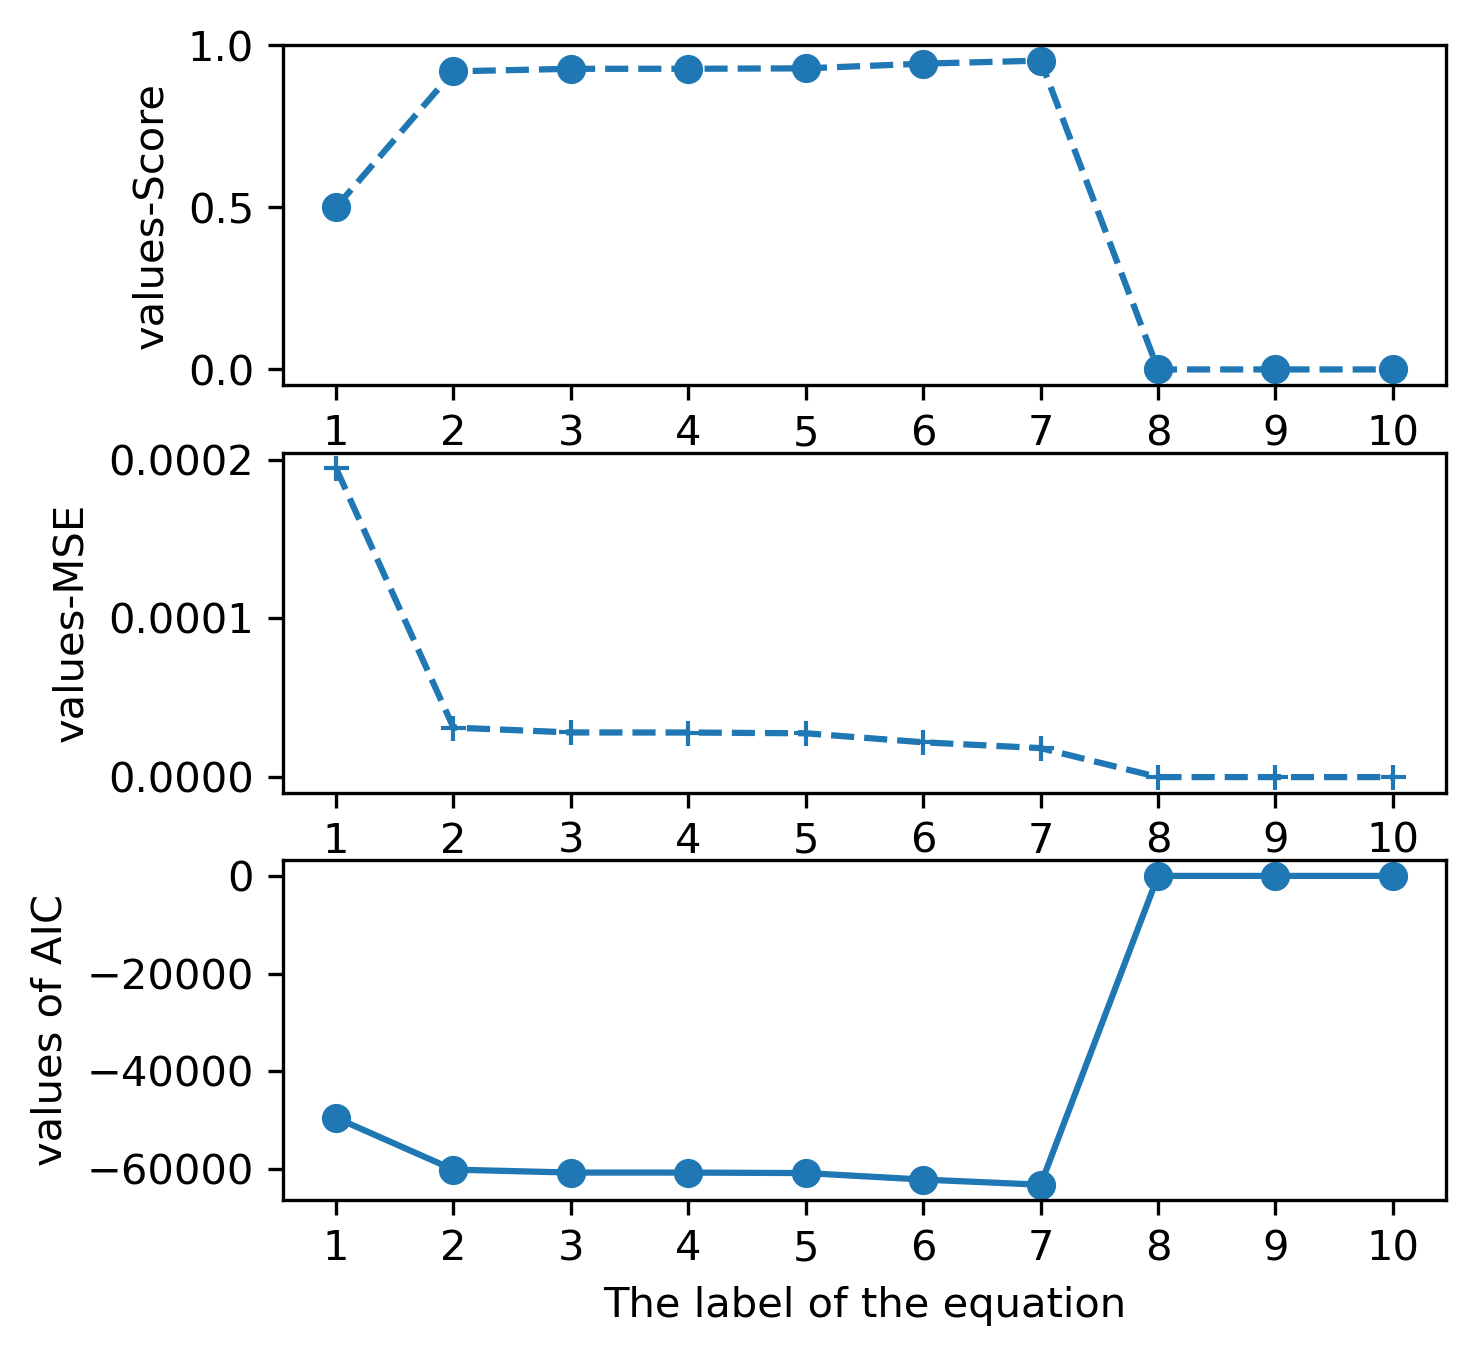

In [231]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_excitory_equation.pdf')
plt.show()

In [232]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_exi = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_exi = y['e0']#dim
model_lineare = LinearRegression(fit_intercept=False)
model_lineare.fit(Xfind_exi,yfind_exi)
ae = model_lineare.coef_
ae

array([-0.21420257, -0.15143242])

In [233]:
# coup_value_type11 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory

In [234]:
t = [-0.225,-0.15]
sm = 0
for i in range(len(ae)):
    s = np.abs(ae[i]-t[i])/(np.abs(ae[i])+np.abs(t[i]))
    sm += s
smape_Ge = sm/len(ae)
print(smape_Ge)

0.014668107171192197


so, type2 is excitatory, and type1 is inhibitory

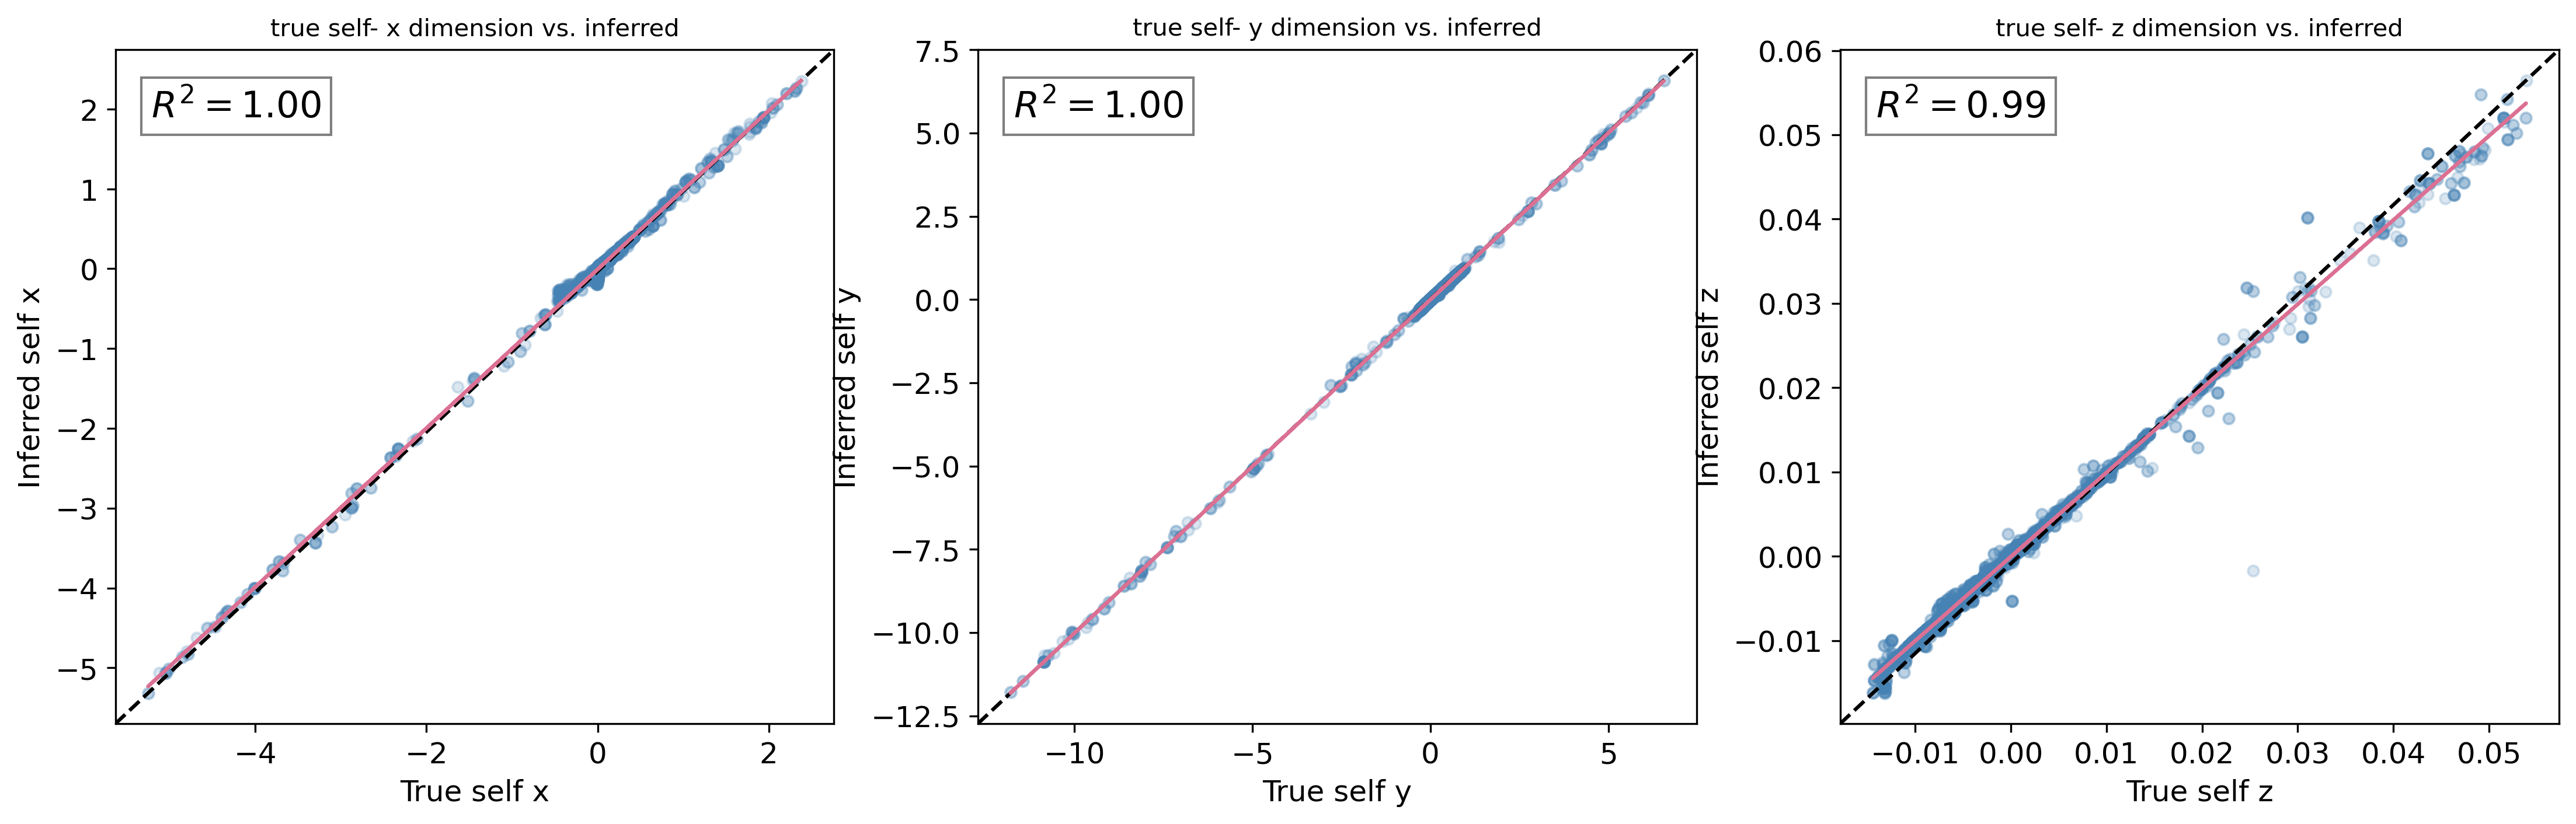

In [235]:
import random
import matplotlib.pyplot as plt
best_selfDyn = selfdyn
sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

R = random.sample(range(0,len(selfdyn['s2'])),4000) 
sx = sx[R]
sx_true = sx_true[R]
sy = sy[R]
sy_true = sy_true[R]
sz = sz[R]
sz_true = sz_true[R]

plt.rcParams.update({'font.size': 12}) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
# plt.savefig('figure2/HR20nodes_selfDynamics_fitting.pdf')
plt.show()
plt.close()

In [236]:
import pandas as pd
sx_true = np.array(sx_true)
sx = np.array(sx)
xdim = pd.concat([pd.DataFrame(sx_true),pd.DataFrame(sx)],axis=1)
sy_true = np.array(sy_true)
sy = np.array(sy)
ydim = pd.concat([pd.DataFrame(sy_true),pd.DataFrame(sy)],axis=1)
sz_true = np.array(sz_true)
sz = np.array(sz)
zdim = pd.concat([pd.DataFrame(sz_true),pd.DataFrame(sz)],axis=1)
selfF = pd.concat([xdim,ydim,zdim],axis=0)
selfF.columns = ['True','Inferred']
selfF['Dimension'] = ['x-dim']*len(R)+['y-dim']*len(R)+['z-dim']*len(R)

Text(0.65, 0.05, '$R^2=1.00$')

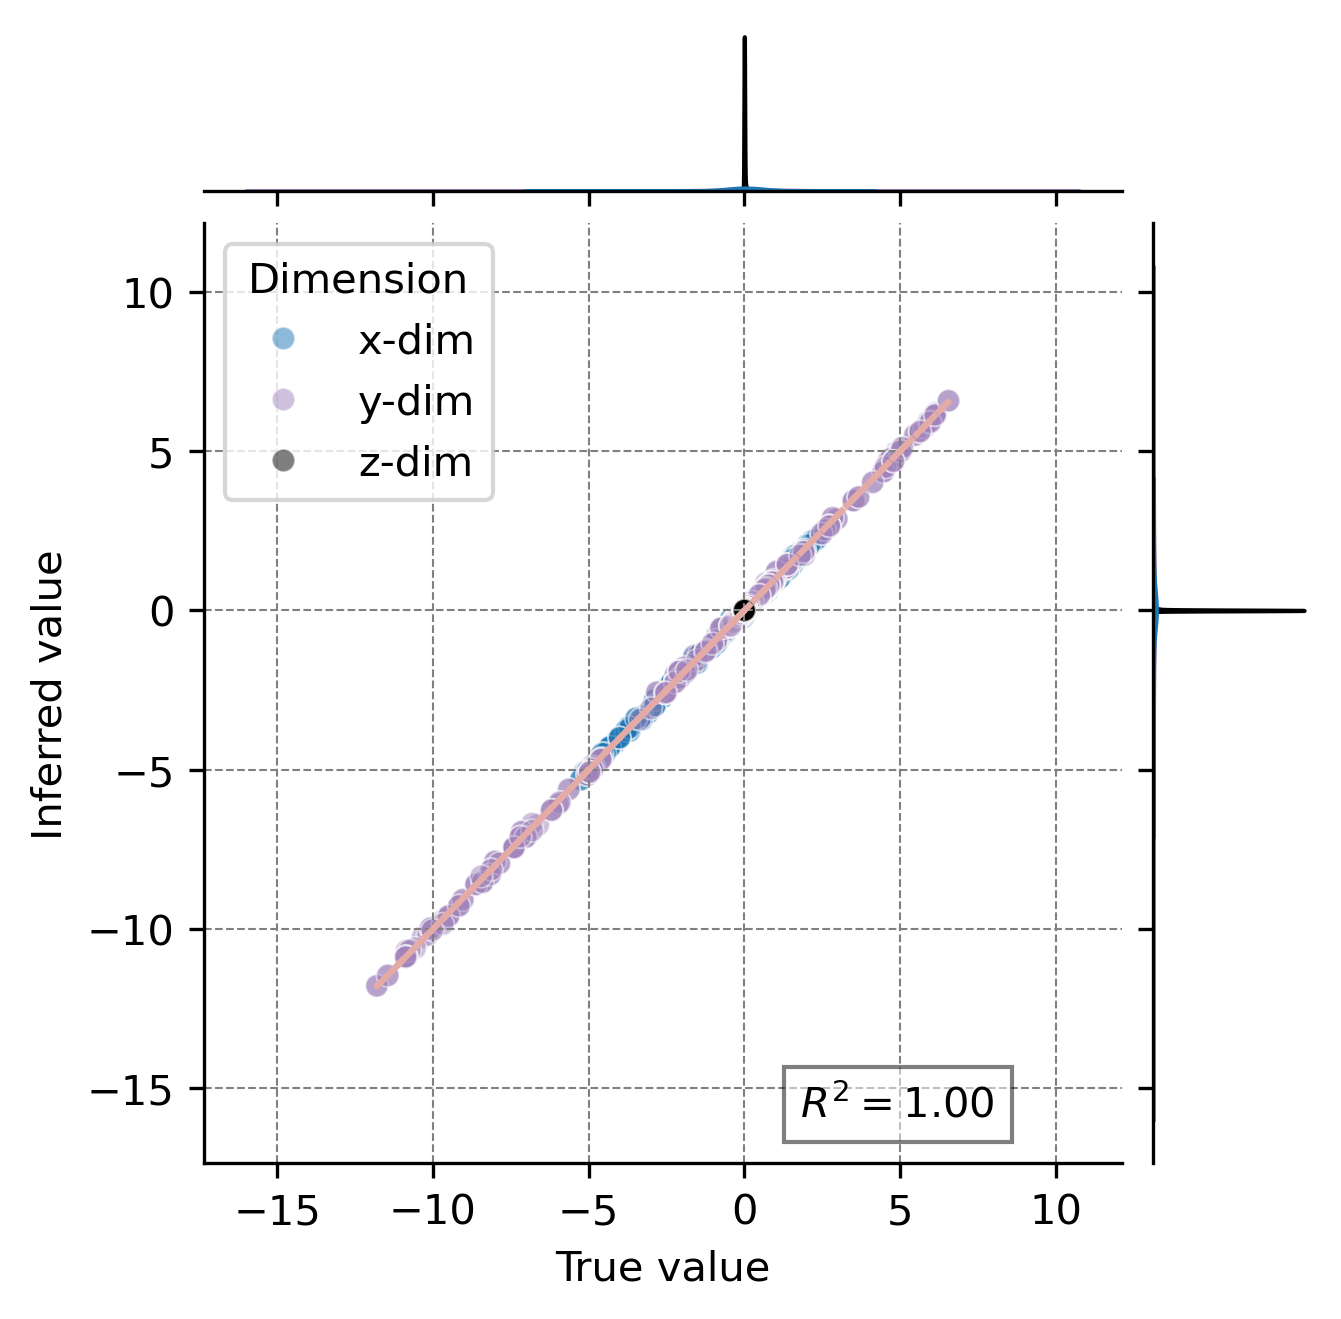

In [237]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
g = sns.jointplot(data=selfF, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Dimension',
                  alpha=0.5, palette = ['C20','#A184BC','k'],
                  joint_kws=dict(s=30),
                  marginal_kws=dict(bw_adjust=5),
                  height=4.5,             
)

g.ax_joint.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(selfF['True'].values,selfF['Inferred'].values,1)
fx = np.poly1d(parameterx)
g.ax_joint.plot(selfF['True'].values,fx(selfF['True'].values),c='#E4AAA5',linestyle='--',lw=1.5)
corrx = np.corrcoef(selfF['True'].values,fx(selfF['True'].values))[0,1]
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# plt.savefig('figure2/HR20nodes_selfDynamics_fitting_joinplot.pdf')


5.254617691040039 11.801453590393066 0.053822457790374756
(3000,)
(3000, 2)


/tmp/ipykernel_104768/196382758.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5,jitter=True, order=order, palette=palette,alpha=0.5)
/tmp/ipykernel_104768/196382758.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100], width=.4, order=order, palette=palette,showfliers=False)


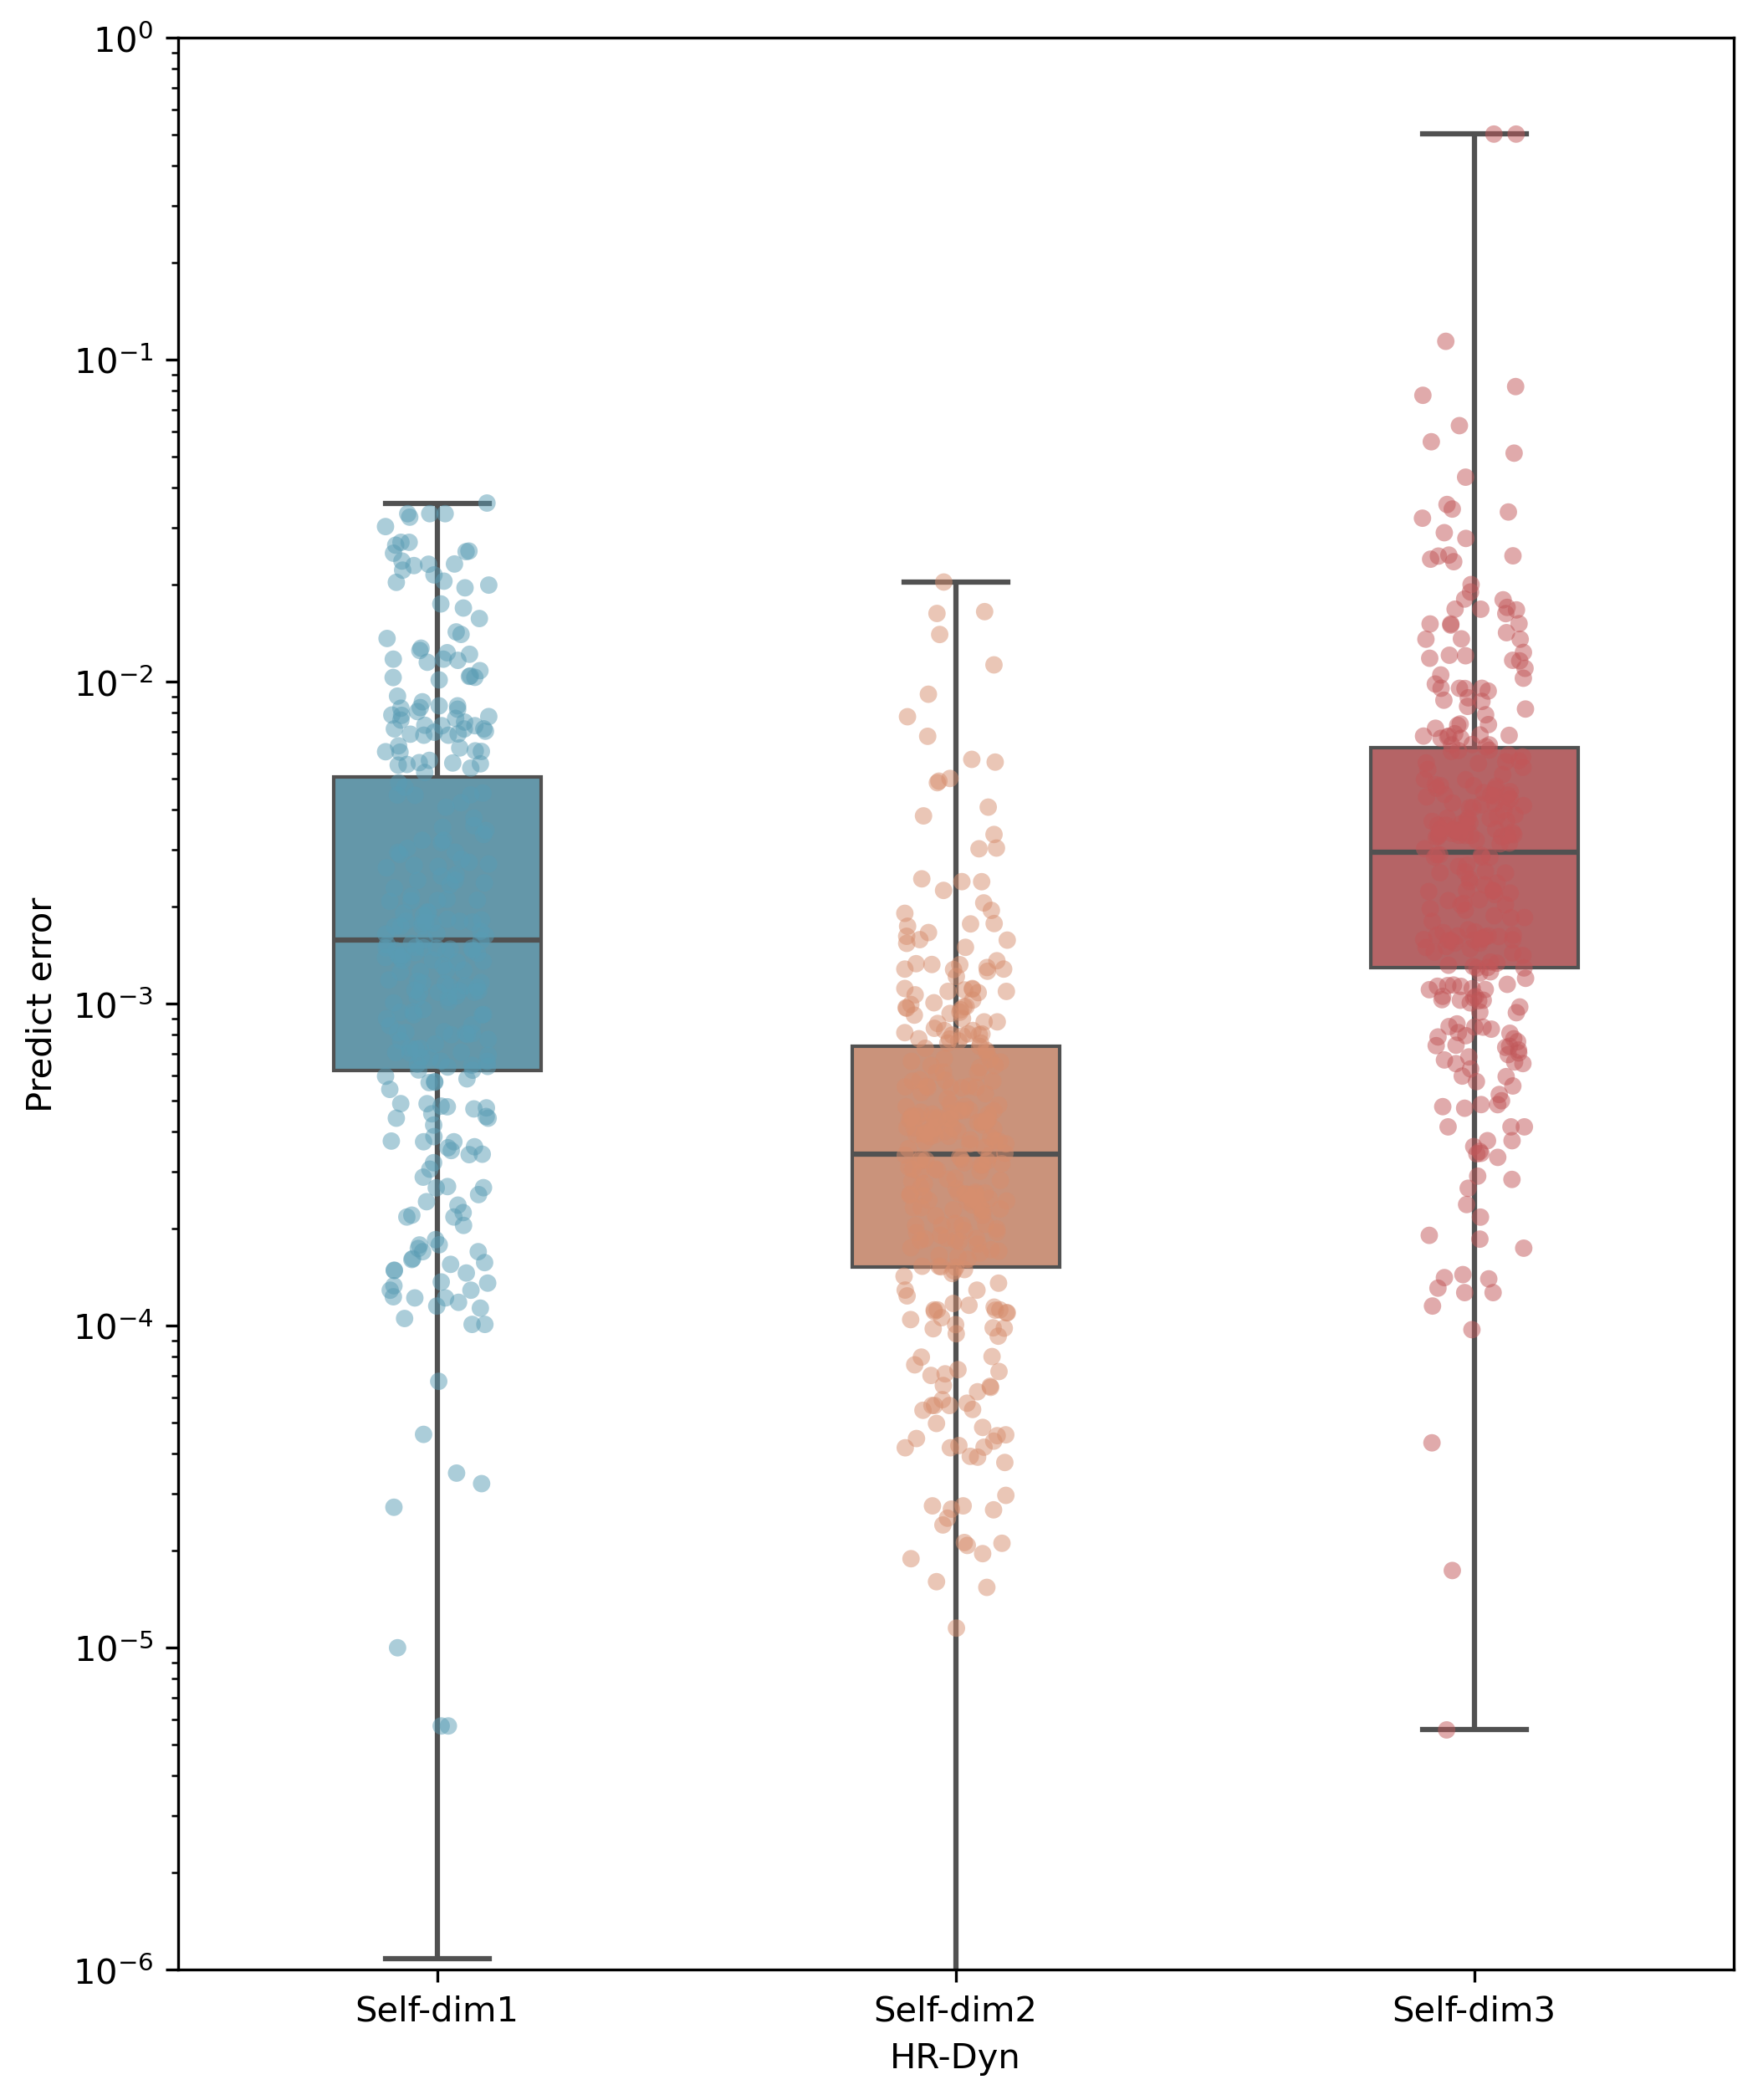

In [238]:
np.random.seed(2035)

sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

index = np.random.randint(0, len(sx_true), 1000)

sx_true = sx_true[index]
sx = sx[index]
sy_true = sy_true[index]
sy = sy[index]
sz_true = sz_true[index]
sz = sz[index]

mx = max(np.abs(sx_true))
my = max(np.abs(sy_true))
mz = max(np.abs(sz_true))
print(mx,my,mz)

norm_errorx = np.abs((sx - sx_true)/mx)
norm_errory = np.abs((sy - sy_true)/my)
norm_errorz = np.abs((sz - sz_true)/mz)

error4self = pd.DataFrame()
errorselfall = np.hstack((norm_errorx,norm_errory,norm_errorz))
print(errorselfall.shape)
error4self['Predict error'] = errorselfall
error4self['HR-Dyn'] = ['Self-dim1']*int(len(index))+['Self-dim2']*int(len(index))+['Self-dim3']*int(len(index))
print(error4self.shape)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
f, ax = plt.subplots(figsize=(8, 10))

order = ['Self-dim1', 'Self-dim2', 'Self-dim3']
palette = ['#599CB4','#D78E6E','#C25759']
desamerror4self = error4self.sample(frac=0.3)
sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5,jitter=True, order=order, palette=palette,alpha=0.5)
sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100], width=.4, order=order, palette=palette,showfliers=False)
ax.set_ylim(1e-6, 1)
ax.set_yscale('log')
for line in ax.lines:  
    line.set_linewidth(1.5)  
# plt.savefig('figure2/v5/HR_self_prediction_error_boxplot.pdf')
plt.show()

## infer equation

In [239]:
best_selfDyn = selfdyn

In [240]:
import sys
from utils.Self_func import *
Dimension = 3
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 3, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
print(self_matrix.columns)

Index(['x1', 'x2', 'x3', 'x1x1', 'x1x2', 'x1x3', 'x2x2', 'x2x3', 'x3x3',
       'x1x1x1', 'x1x1x2', 'x1x1x3', 'x1x2x2', 'x1x2x3', 'x1x3x3', 'x2x2x2',
       'x2x2x3', 'x2x3x3', 'x3x3x3'],
      dtype='object')


2nd self dimension

In [241]:
goal = best_selfDyn['s2'].values
goal = pd.DataFrame(data = goal, columns =['s2'])
X = self_matrix.copy()
y = goal.copy()

In [242]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [243]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9998739673790988
Best threshold: 0.001


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e+01, tolerance: 8.601e+00
  model = cd_fast.enet_coordinate_descent(


In [244]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [245]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x1x1x2      1.000000e-10
x1x2x2      8.084269e-04
x2x2        3.173907e-03
x1x2x3     -8.493073e-03
x1         -3.308859e-02
x2x3       -4.282525e-02
x1x1x1     -6.811307e-02
x1x1x3     -1.676081e-01
x2         -8.368682e-01
x1x1       -4.367715e+00
constant    9.796858e-01
dtype: float64


In [246]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-1]].values.reshape(-1,1)
            X = pd.DataFrame(X,columns=[imp_cons.index[-1]])
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
        X.columns = ['constant']
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    if Score>0.95:
        break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant   -0.0
dtype: float64
-0.0002080757953468737 2.1575361762668113 7691.6691151357745 constant


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.242683
x1x1       -1.208458
dtype: float64
0.2384301867144225 1.6427726017007211 4967.854251554447 x1x1


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.010591
x1x1       -4.994405
x2         -1.000528
dtype: float64
0.9997271276022784 0.0005886095941794111 -74371.47422298745 x2


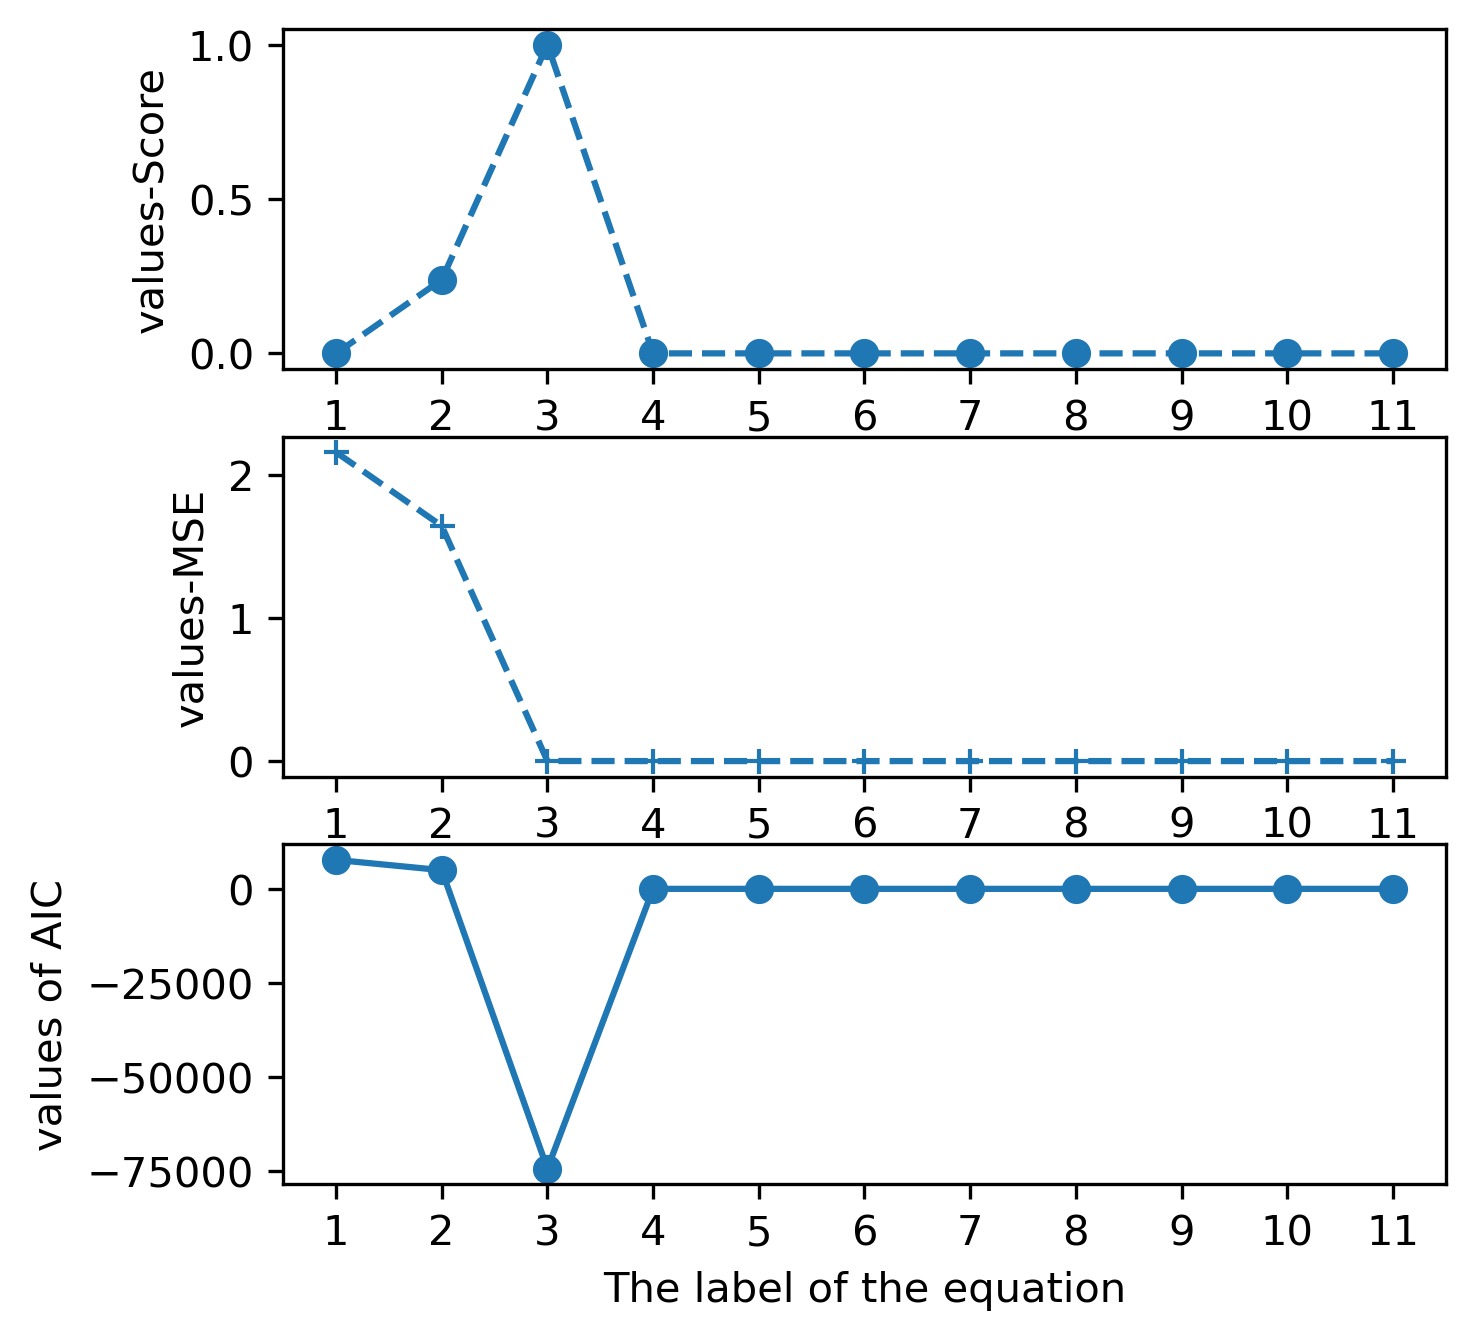

In [247]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_selfdim2_equation_only_polynomial.pdf')
plt.show()

In [248]:
X = self_matrix.copy()
y = goal.copy()
Xfind = pd.concat([X['x2'],X['x1x1']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s2']

model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
b = model_linear.coef_
b1 = b.tolist()
print('constant:',model_linear.intercept_)
b1.append(model_linear.intercept_)
b1 = np.array(b1)
print(b1)

constant: 0.9934092966271737
[-1.00210677 -5.00351562  0.9934093 ]


In [249]:
# sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']

In [250]:
smape_dim2 = np.sum((np.abs(b1 - [-1,-5,1])) / (np.abs(b1 + [-1,-5,1])))/len(b1)
smape_dim2

0.0015699879742378374

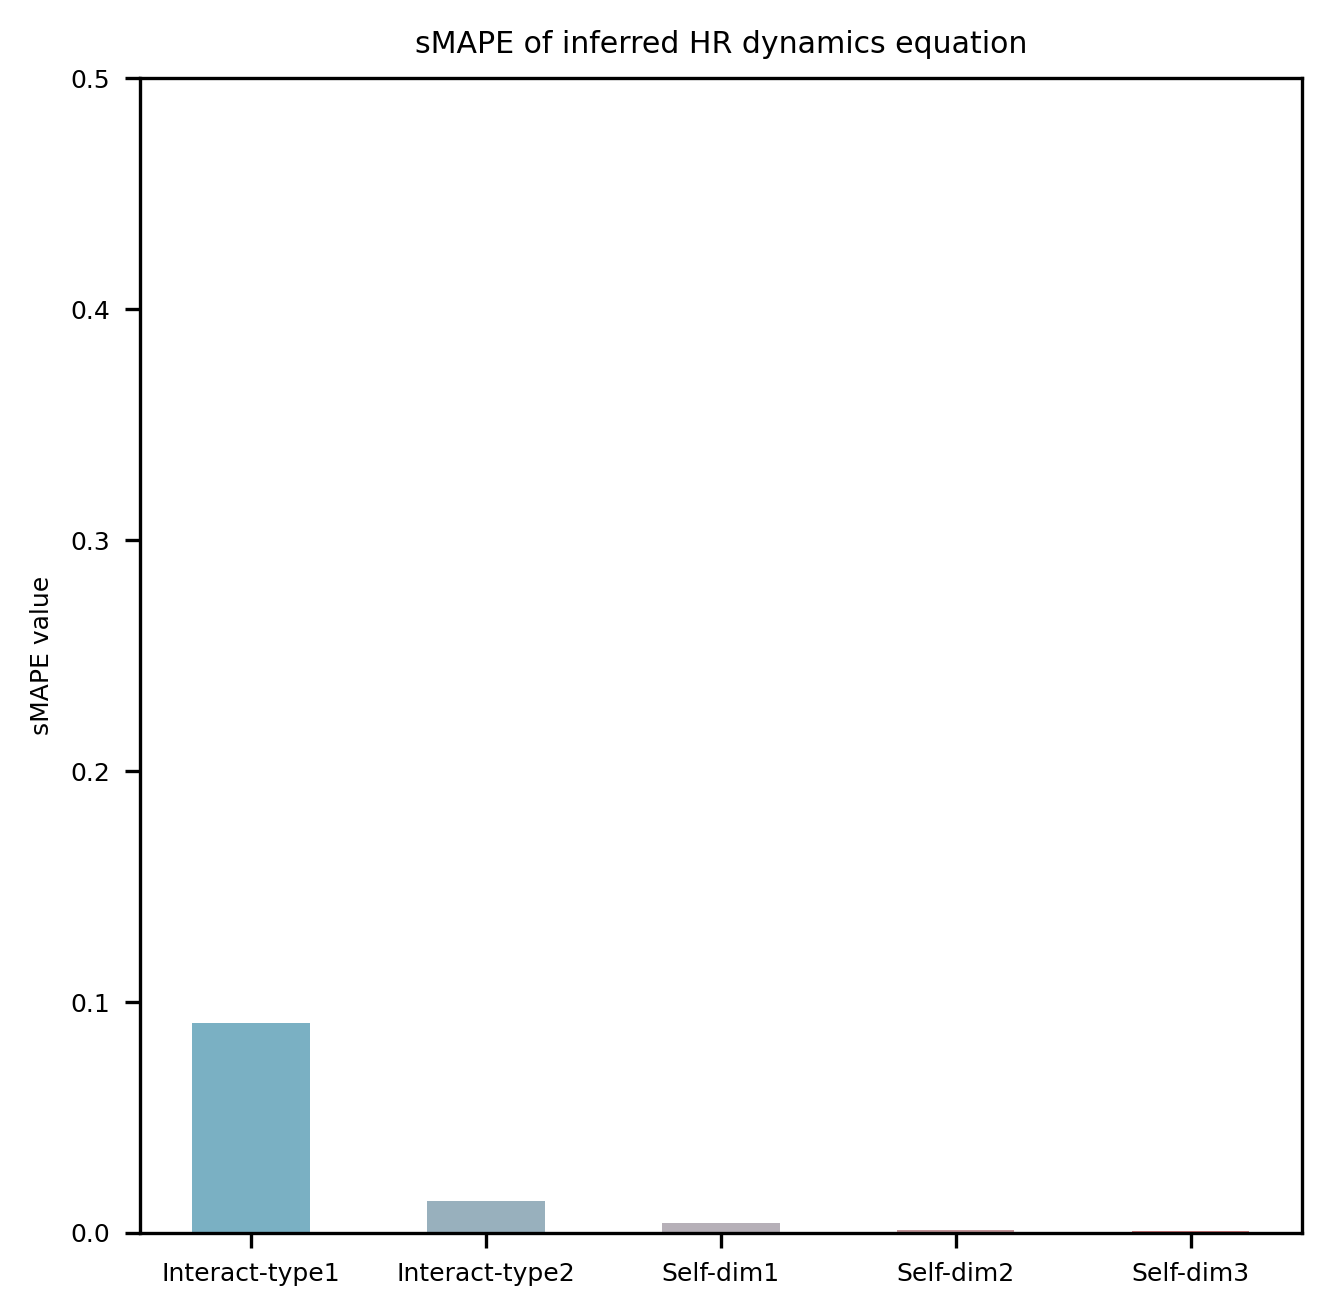

In [251]:
import matplotlib.pyplot as plt
import numpy as np  
from matplotlib.colors import LinearSegmentedColormap   

plt.rcParams.update({'font.size': 6})
values = np.load('inference_results_smape.npy')
labels = ['Interact-type1','Interact-type2', 'Self-dim1', 'Self-dim2', 'Self-dim3']

start_color = '#599CB4'  
end_color = '#C25759' 
mid_color = '#A49DA6'  
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, mid_color, end_color])
colors = custom_cmap(np.linspace(0, 1, len(labels)))
fig = plt.figure(figsize=(5,5))
plt.bar(labels, values, color=colors,width=0.5,alpha = 0.8)
# plt.semilogy()
plt.ylim(0,0.5)

plt.title('sMAPE of inferred HR dynamics equation')
plt.ylabel('sMAPE value')
# plt.savefig('figure2/v6/sMAPE_HR_equationinfer2_nolog.pdf')

plt.show()


## direct results from training process

In [252]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999_lam0.0001_20251013_191841.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 1999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

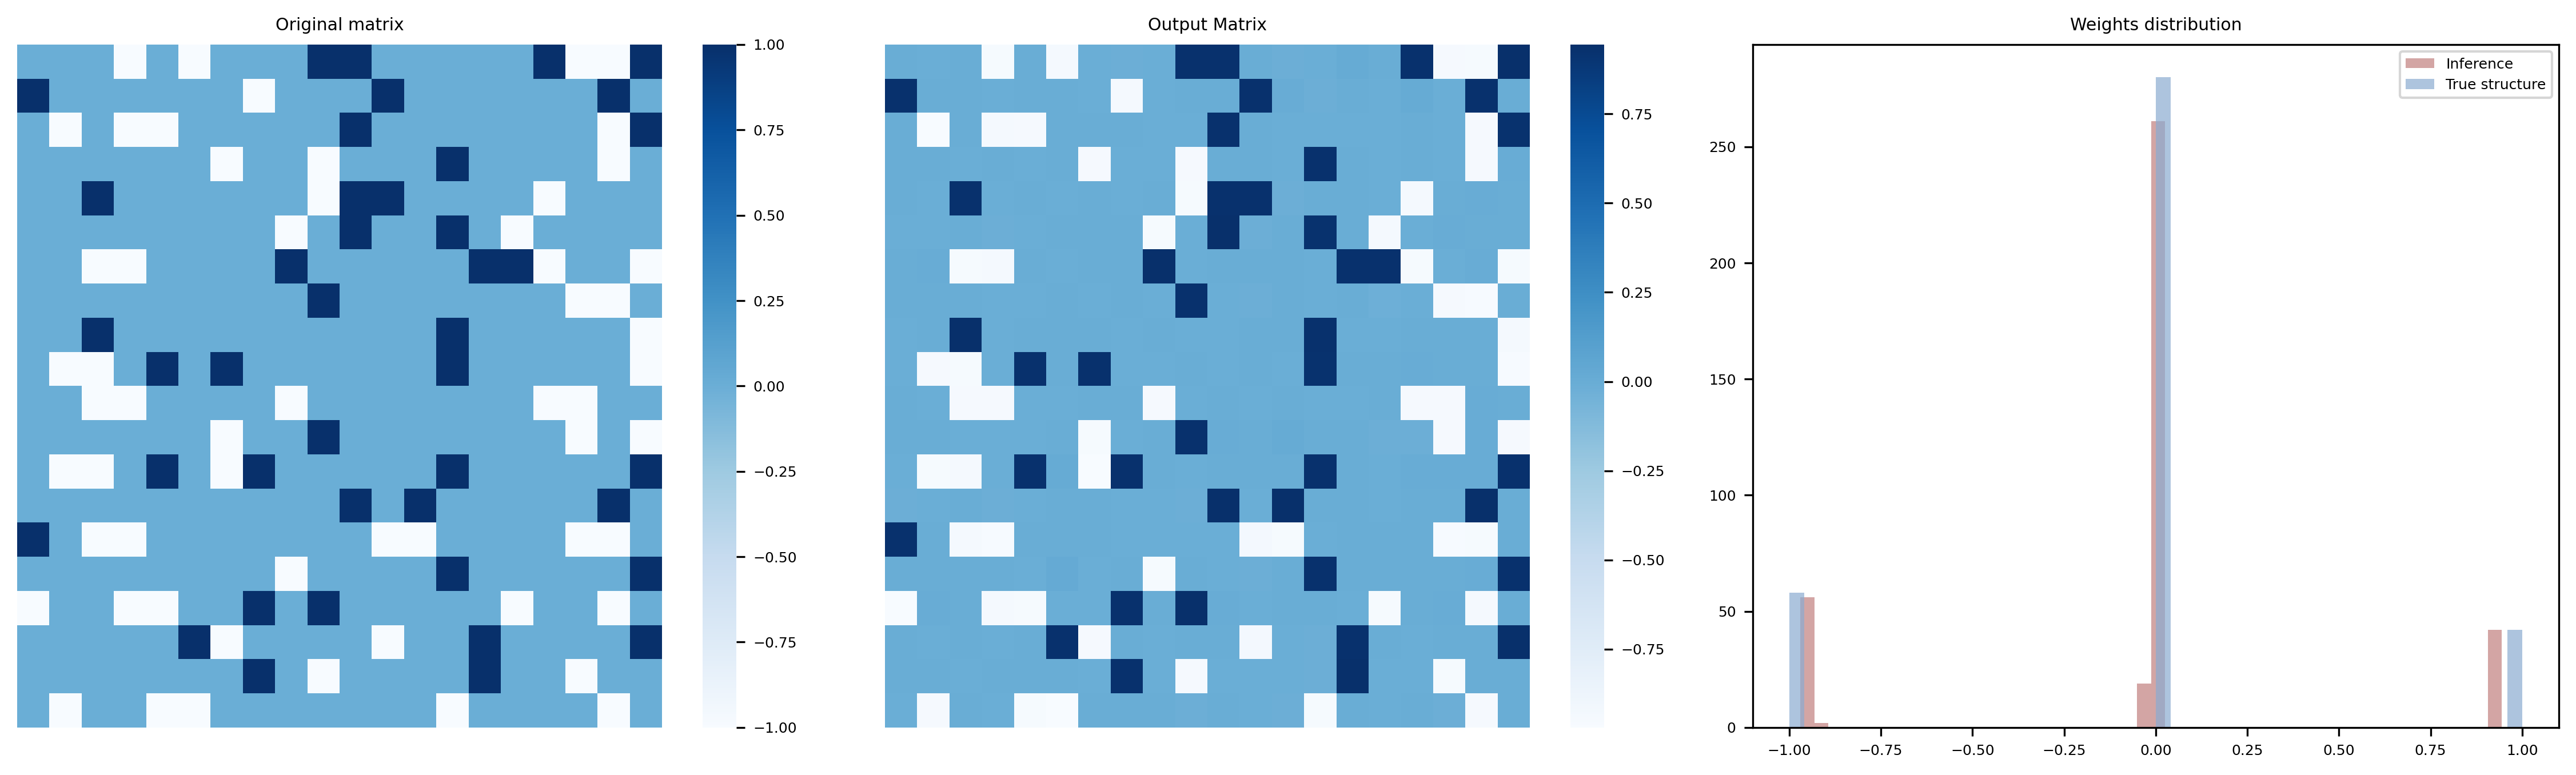

In [253]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

# Stru = Stru.T# the edges we learn is i to j, we want to show Aij(j to i).

Stru = -Stru
bestWei = -bestWei

selected_elements = objectAij[mask]
object_edges_rem_diag = selected_elements.reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
snb.heatmap(objectAij,cmap='Blues', ax=ax1)
ax1.set_title('Original matrix')
snb.heatmap(Stru, cmap='Blues', ax=ax2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.hist(object_edges_rem_diag,bins=50,alpha=0.7, color='#8BACD1', label='True structure')
plt.legend()
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_structure.pdf')

plt.tight_layout()
plt.show()

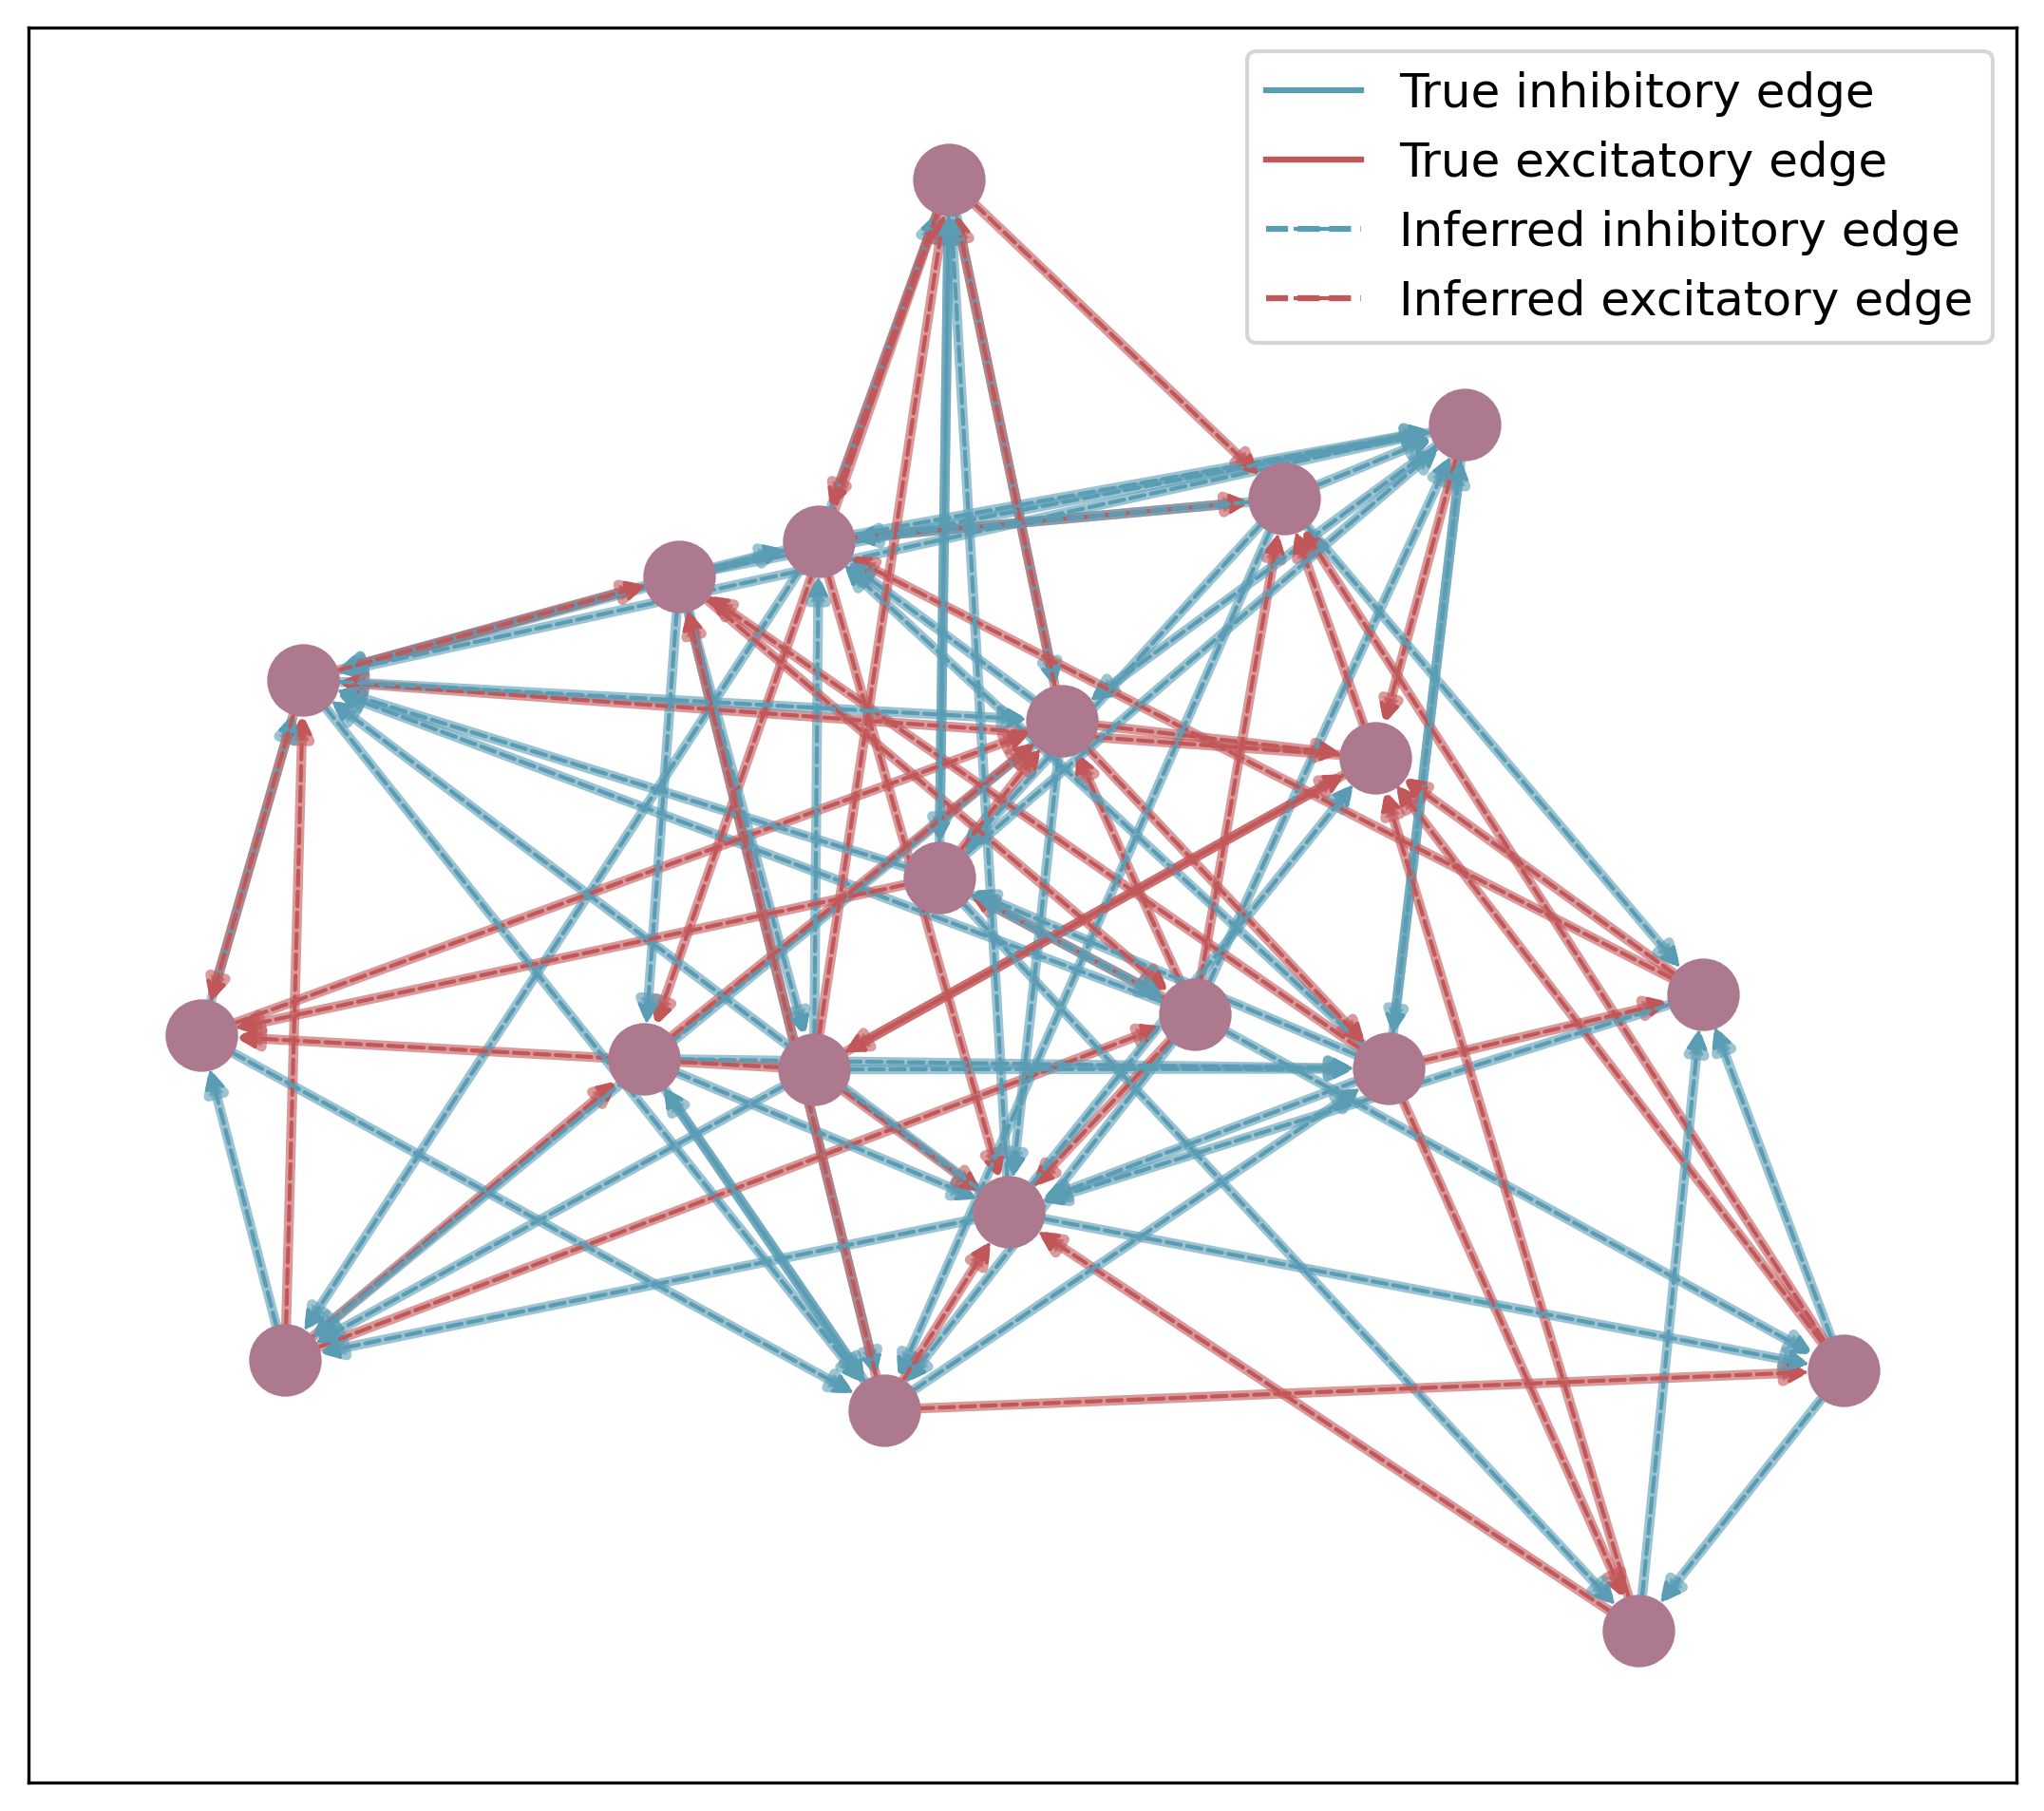

In [254]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

np.random.seed(2052)
plt.rcParams.update({'font.size': 12})  
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(9, 8))
G = nx.DiGraph()

palette = ['#C25759','#599CB4']
num_nodes = objectAij.shape[0]
G.add_nodes_from(range(num_nodes))

edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            edge_colors.append('#C25759') # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            edge_colors.append('#599CB4') # inhibitroy edges are green

pos = nx.spring_layout(G) 
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_color='#AC798F', node_size=300)
# nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')
nx.draw_networkx_edges(G, pos, width=2.5,edge_color=edge_colors,alpha=0.6,style='solid')

infer_edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            infer_edge_colors.append('#C25759')  # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            infer_edge_colors.append('#599CB4')  # inhibitroy edges are green

nx.draw_networkx_edges(G, pos, width=1,edge_color=infer_edge_colors,alpha=1,style='dashed')

# create legend
true_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=15, label='True inhibitory edge', linestyle='solid')
true_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=15, label='True excitatory edge', linestyle='solid')
infer_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=10, label='Inferred inhibitory edge', linestyle='dashed')
infer_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=10, label='Inferred excitatory edge', linestyle='dashed')
plt.legend(handles=[true_inh, true_exi,infer_inh,infer_exi])
# plt.savefig('figure2/networkx_graph_20nodes.pdf')
plt.show()

(20, 20)


Text(0.5, 1.0, 'Structure inference error')

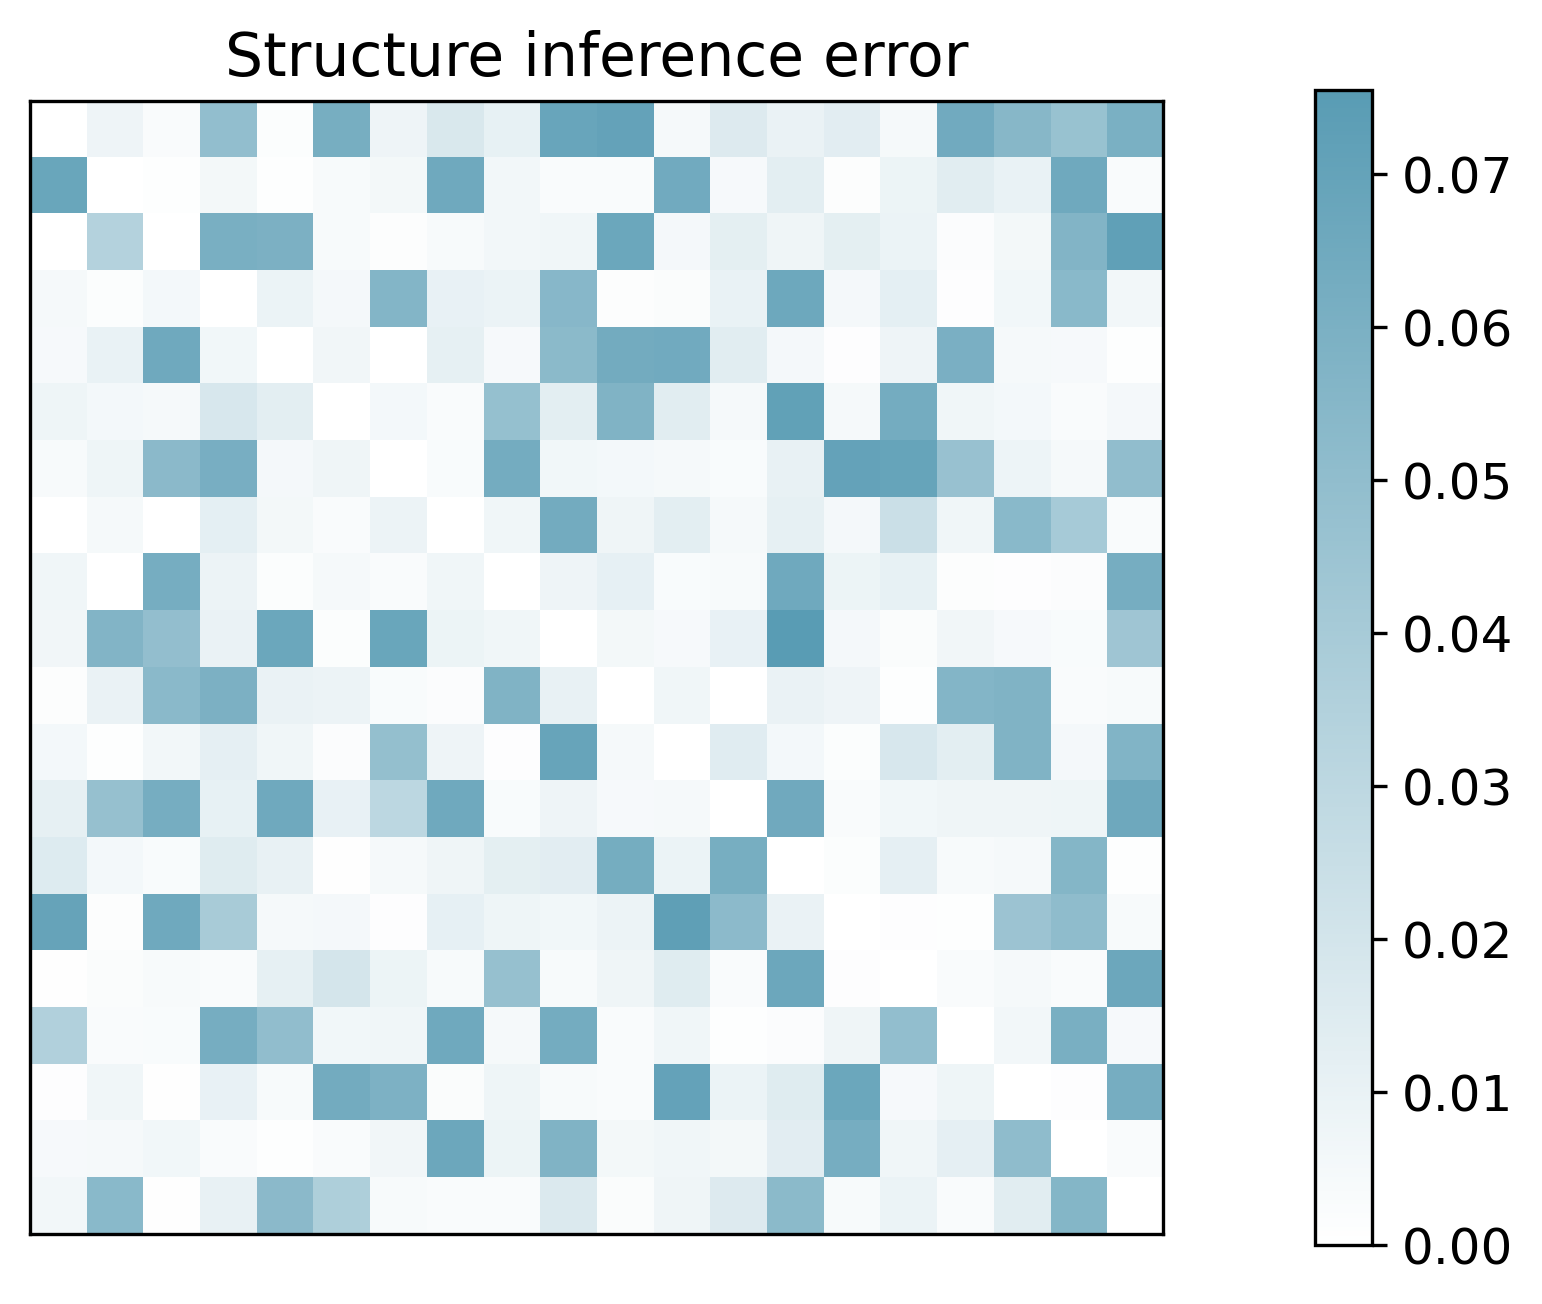

In [255]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 5))
struc_error = np.abs(objectAij-Stru)
# colors = ['#599CB4','#C25759'] 
colors = ['#ffffff','#599CB4'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
print(struc_error.shape)
im = plt.imshow(struc_error, cmap=cmap)
cbar = plt.colorbar(im,pad = 0.1)
plt.xticks([])
plt.yticks([])
plt.title('Structure inference error')
# plt.savefig('figure2/HR20nodes_inferror_green.pdf')

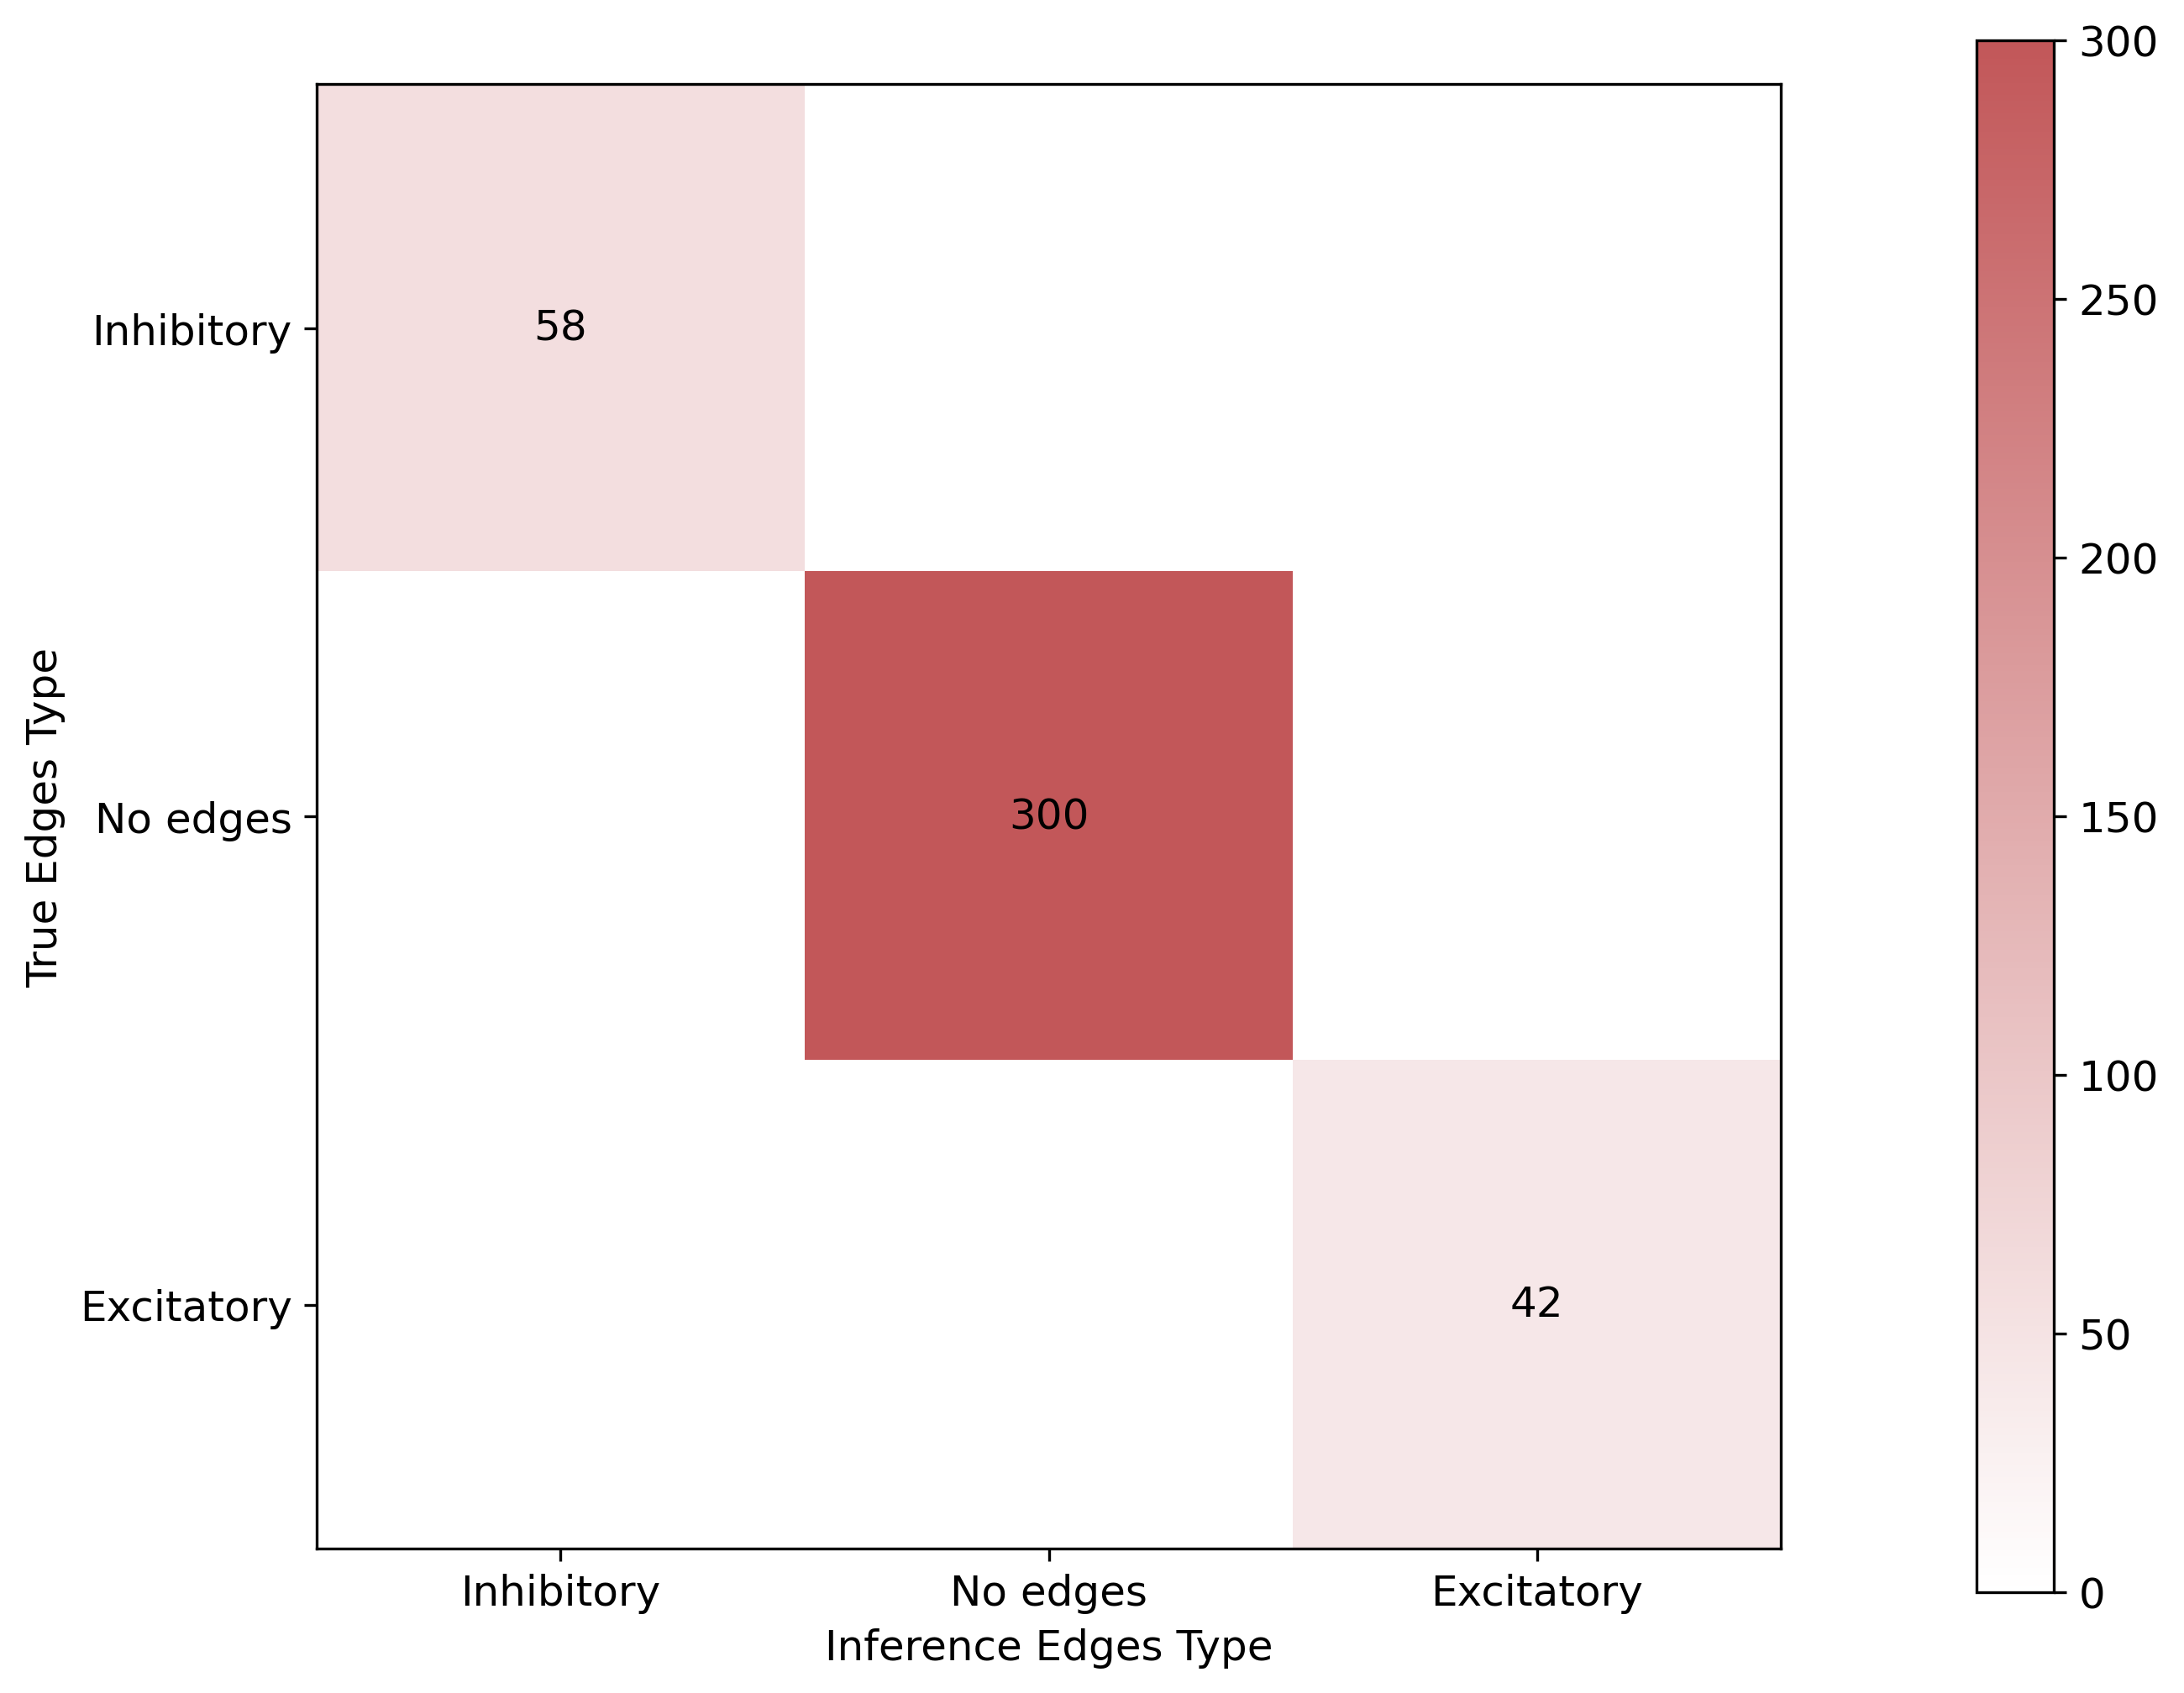

In [256]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ground_truth = objectAij.reshape(-1)
prediction = Stru.reshape(-1)

prediction_rounded = np.round(prediction)

cm = confusion_matrix(ground_truth, prediction_rounded)
colors = ['#ffffff','#C25759'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(10,8))
cfus = plt.imshow(cm, cmap=cmap)
cbar = plt.colorbar(cfus,pad = 0.1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i ==j :
            plt.text(j, i, f'{int(cm[i, j])}', ha='center', va='center', color='k')

plt.xticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.yticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.xlabel('Inference Edges Type')
plt.ylabel('True Edges Type') 
# plt.savefig('figure2/HR20nodes_confusion.pdf')
plt.show()


In this confusion matrix, the rows represent the actual edge categories, and the columns represent the inferred edge categories. The value in each cell indicates the number of times the corresponding actual edge type was inderred as the corresponding predicted edge type. Cells on the diagonal represent correct predictions, while cells off the diagonal represent incorrect predictions.